In [1]:
from xmitgcm import open_mdsdataset
import xarray as xr
import numpy as np
import xgcm
import datetime
import os
import scipy
from matplotlib import pyplot as plt 



from mpl_toolkits.mplot3d import Axes3D 
from scipy import interpolate
import scipy.io as sio

import warnings; warnings.simplefilter('ignore')


#from dask.distributed import Client
#client = Client()
#client


In [2]:
# code from Ed Doddridge
def invert_map(fldZ, zC, zF, fldVec, verbose=False):
    """
    [ Function ] 
        [kFld,zFld,k0Fld]=invert_map(fldZ,zC,zF,fldVec)

    [Description]
    Find vertical index (kFld) and depth (zFld)
    for each element of the vector fldVec using fldZ, zC and zF

    [Input]
    fldZ    : Potential density on the model's vertical grid, 2D array (nr x nx) 
    zC      : Depth at the grid center, vector (nr)
    zF      : Depth at the interface, vector (nr+1)
    fldVec  : potential density initially defined in Layers package, vector(ny) (mky, nz?)
    verbose : Boolean flag, if True, print warnings

    [Output]
    kFld  : vertical index at the layers interfaces, 2D array (ny, nx)
    zFld  : depth at the layers interfaces 2D array (ny, nx)
    k0Fld : vertical index before accounting fraction, 2D array (nx,ny)
    """
    ny=len(fldVec)
    [nr,nx] = fldZ.shape
    kFld=np.zeros([ny,nx]) 
    zFld=np.zeros([ny,nx]) 
    k0Fld=np.zeros([ny,nx])
    #- extended vert. res:
    zExt = np.append(zC,zF[-1])

    #%- assume field=0 @ land-pts and field > 0 elsewhere:
    MxV=fldZ.min() 
    botV=fldVec.min() # (mky switch three to minimum)
    botV=np.minimum(botV,MxV)-1
    var=fldZ.copy()
    var[np.nonzero(fldZ==0)] = botV

    
    fldV=np.ones([nr+1,nx])*botV 
    fldV[:-1,:] = var

    mnV=np.min(fldV)
    var1d = fldV.flatten()

    for j,ff in enumerate(fldVec):
        kk=np.zeros(nx, dtype='int32') 
        zz=np.zeros(nx)
        var=(fldV[1:nr+1,:]-ff)*(fldV[:-1,:]-ff)
        #print((fldV[1,:]-ff)*(fldV[0,:]-ff))
        [Ks, Is] = np.nonzero(var < 0) # (mky changed sign, changed back)
        kk[Is] = Ks

        [Ke, Ie] = np.nonzero(fldV[:-1,:] == ff)
        nEx=len(Ie) 
        nu=0
        if nEx > 0:
            Iu = np.unique(Ie) 
            nu = len(Iu)
            if nu == nEx:
                kk[Ie]=Ke
            else:
                if verbose:
                    print('warning 1')
                Ku = Iu.copy()
                for l in xrange(nu):
                    L = np.nonzero(Ie == Iu[l])
                    Ku[l] = Ke[L[0]]
                kk[Iu] = Ku

        k1 = np.maximum(kk,0)
        k2 = np.minimum(kk+1,nr)
        ik1 = k1*nx 
        ik1 = ik1 + np.arange(nx)
        ik2 = k2*nx 
        ik2 = ik2 + np.arange(nx)
        k1 = k1.astype('int32') 
        k2 = k2.astype('int32')
        ik1 = ik1.astype('int32') 
        ik2 = ik2.astype('int32')

        dfld = var1d[ik2] - var1d[ik1] 
        dfld[np.nonzero(kk==0)] = 1.
        [J]=np.nonzero(dfld <= 0 )

        dfld = 1./dfld
        frac = ff - var1d[ik1] 
        frac = frac * dfld
        zz = zExt[k1] + frac*(zExt[k2]-zExt[k1])
        dk = frac * (k2 - k1)
        zz[np.nonzero(kk==0)] = 0.
        dk[np.nonzero(kk==0)] = 0.

        [I1]=np.nonzero(fldV[0,:] < ff) # (mky changed sign, undone creates infinity)

        if len(I1) > 0:
            zz[I1]=zF[0] 
            kk[I1]=0

        if (len(I1)+len(Is)+nu != nx):
            #fprintf(' error for j= %i, ff= %f : nSt= %i , nEx= %i , nL1= %i\n', ...
            #j,ff,length(Is),nu,length(I1))
            if verbose:
                print('warning 2')
        #- save in output array:
        kFld[j,:]=kk+dk
        zFld[j,:]=zz
        k0Fld[j,:]=kk
        
    return kFld, zFld, k0Fld

def map2z(psiRHO,kzLay,zkLay,hFacS):
   # """
   # Map Psi from (lat-rho) to (lat-dep)
   # """
    [nr,ny,nx] = hFacS.shape
    msk = np.ceil(hFacS)
    mskV = msk[:,:,0]
    
    [nlp,ny] = psiRHO.shape
    nLay = nlp - 1
    
    kBot = np.round(np.sum(mskV,axis=0)).astype('int32')
    psiRes = np.zeros([nr+1,ny])
    for i in range(1,ny):
        [J] = np.nonzero(kzLay[:,i]>0)
        if len(J)*kBot[i] > 0:
            j1 = J.min()
            j1 = np.maximum(1,j1-1)
            z1 = np.flipud(kzLay[j1:nlp,i])
            v1 = np.flipud(psiRHO[j1:nlp,i])
            zg = np.arange(kBot[i])
            vg = np.interp(zg,z1,v1)
         
            psiRes[:kBot[i],i] = vg
    
    return psiRes



def calc_psi_res(LaVH, LaTr, its):
# """Calculate Psi_res on both k- and density-levels."""

    hFacS = np.array(ds.hFacS)
    [nt, nz, ny, nx] = LaVH.shape
    XC = ds.XC
    DXG = ds.dxG
    YC = ds.YC
    RC = ds.Z
    RF = ds.Zp1
    [nr,ny,nx] = hFacS.shape
    layers_bounds = np.array(ds.layer_1TH_bounds)

    if layers_bounds[0]>1000:
        layers_bounds = layers_bounds - 1000
    nl = len(layers_bounds)
    rLayC = (layers_bounds[1:]+layers_bounds[:-1])/2
    nlc = len(rLayC)

    Psi_res_Rho = np.zeros([nt,nl,ny])
    Psi_res_z = np.zeros([nt,nr+1,ny])
    kzLay = np.zeros([nt,nl,ny])
    zkLay = np.zeros([nt,nl,ny])

    for t in range(nt):
        for k in range(nlc-1,-1,-1):
            lavhdx = LaVH[t,k,:,:] * DXG;
            Psi_res_Rho[t,k,:] = Psi_res_Rho[t,k+1,:] + np.nansum(lavhdx, axis=1);


    znl_mean_LaTr = np.nanmean(LaTr, axis=-1) 

    for t in range(nt):
        [kzLay[t,:,:],zkLay[t,:,:],_]=invert_map(znl_mean_LaTr[t,:,:],RC,RF,layers_bounds)
        Psi_res_z[t,:,:] = map2z(Psi_res_Rho[t,:,:],kzLay[t,:,:],zkLay[t,:,:],hFacS)


    Psi_rho = xr.DataArray(data=Psi_res_Rho,
                coords={'time':its,
                    'sigmaF':layers_bounds[:],
                    'YC':YC[:]},
                dims=['time', 'sigmaF', 'YC'])
    Psi_z = xr.DataArray(data=Psi_res_z,
                coords={'time':its,
                    'Zp1':RF,
                    'YC':YC[:]},
                dims=['time', 'Zp1', 'YC'])

    kzLay = xr.DataArray(data=kzLay,
                coords={'time':its,
                    'sigmaF':layers_bounds[:],
                    'YC':YC[:]},
                dims=['time', 'sigmaF', 'YC'],
                attrs={'description':'index (in k-space) of each layer interface at each Y location'})
    zkLay = xr.DataArray(data=zkLay,
                coords={'time':its,
                    'sigmaF':layers_bounds[:],
                    'YC':YC[:]},
                dims=['time', 'sigmaF', 'YC'],
                attrs={'description':'depth (in m) of each layer interface at each Y location'})


    return Psi_rho, Psi_z, kzLay, zkLay

def calc_psi_mean(LaV, LaH, LaTr, its):
# """Calculate Psi_res on both k- and density-levels."""

    hFacS = np.array(ds.hFacS)
    [nt, nz, ny, nx] = LaV.shape
    XC = ds.XC
    DXG = ds.dxG
    YC = ds.YC
    RC = ds.Z
    RF = ds.Zp1
    [nr,ny,nx] = hFacS.shape
    layers_bounds = np.array(ds.layer_1TH_bounds)

    if layers_bounds[0]>1000:
        layers_bounds = layers_bounds - 1000
    nl = len(layers_bounds)
    rLayC = (layers_bounds[1:]+layers_bounds[:-1])/2
    nlc = len(rLayC)

    Psi_res_Rho = np.zeros([nt,nl,ny])
    Psi_res_zonal = np.zeros([nt,nl,ny])
    Psi_res_z = np.zeros([nt,nr+1,ny])
    Psi_res_zonal_z = np.zeros([nt,nr+1,ny])
    kzLay = np.zeros([nt,nl,ny])
    zkLay = np.zeros([nt,nl,ny])
    
    LaVH = ds.dxG[0,0]*LaV*LaH

    for t in range(nt):
        #for k in range(nlc-1,-1,-1):
        for k in range(0,nlc,1):
            lavhdx = LaVH[t,k,:,:]
            lavdx = LaV[t,k,:,:];
            lah = LaH[t,k,:,:]
            Psi_res_Rho[t,k,:] = Psi_res_Rho[t,k-1,:] - lavhdx.sum(dim='XC',skipna=False)
            #print(np.nansum(lavhdx,axis=1))
            Psi_res_zonal[t,k,:] = Psi_res_zonal[t,k-1,:] - (lavdx.sum(dim='XC'
                                )/nx)*(lah.sum(dim=['XC']))/nx*4e6
            #print(np.array((ds.dxG.where(lah !=0)).sum(dim='XC')))
    znl_mean_LaTr = np.nanmean(LaTr, axis=-1) 
    
    
    

    for t in range(nt):
        [kzLay[t,:,:],zkLay[t,:,:],_]=invert_map(znl_mean_LaTr[t,:,:],RC,RF,layers_bounds)
        Psi_res_z[t,:,:] = map2z(Psi_res_Rho[t,:,:],kzLay[t,:,:],zkLay[t,:,:],hFacS)
        Psi_res_zonal_z[t,:,:] = map2z(Psi_res_zonal[t,:,:],kzLay[t,:,:],zkLay[t,:,:],hFacS)


    Psi_rho = xr.DataArray(data=Psi_res_Rho,
                coords={'time':its,
                    'sigmaF':layers_bounds[:],
                    'YC':YC[:]},
                dims=['time', 'sigmaF', 'YC'])
    Psi_zonal = xr.DataArray(data=Psi_res_zonal,
                coords={'time':its,
                    'sigmaF':layers_bounds[:],
                    'YC':YC[:]},
                dims=['time', 'sigmaF', 'YC'])
    Psi_z = xr.DataArray(data=Psi_res_z,
                coords={'time':its,
                    'Zp1':RF,
                    'YC':YC[:]},
                dims=['time', 'Zp1', 'YC'])
    Psi_zonal_z = xr.DataArray(data=Psi_res_zonal_z,
                coords={'time':its,
                    'Zp1':RF,
                    'YC':YC[:]},
                dims=['time', 'Zp1', 'YC'])

    kzLay = xr.DataArray(data=kzLay,
                coords={'time':its,
                    'sigmaF':layers_bounds[:],
                    'YC':YC[:]},
                dims=['time', 'sigmaF', 'YC'],
                attrs={'description':'index (in k-space) of each layer interface at each Y location'})
    zkLay = xr.DataArray(data=zkLay,
                coords={'time':its,
                    'sigmaF':layers_bounds[:],
                    'YC':YC[:]},
                dims=['time', 'sigmaF', 'YC'],
                attrs={'description':'depth (in m) of each layer interface at each Y location'})


    return Psi_rho, Psi_zonal, Psi_z ,Psi_zonal_z,kzLay, zkLay

/glade/p/univ/umit0025/newcarbon/dop_mean
0.1499955


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


TypeError: unsupported operand type(s) for *: 'float' and 'QuadContourSet'

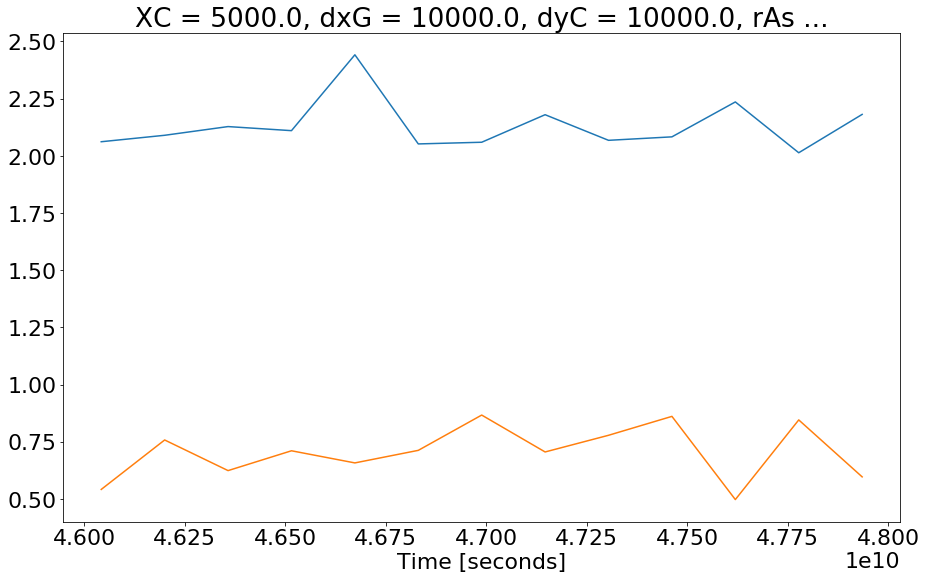

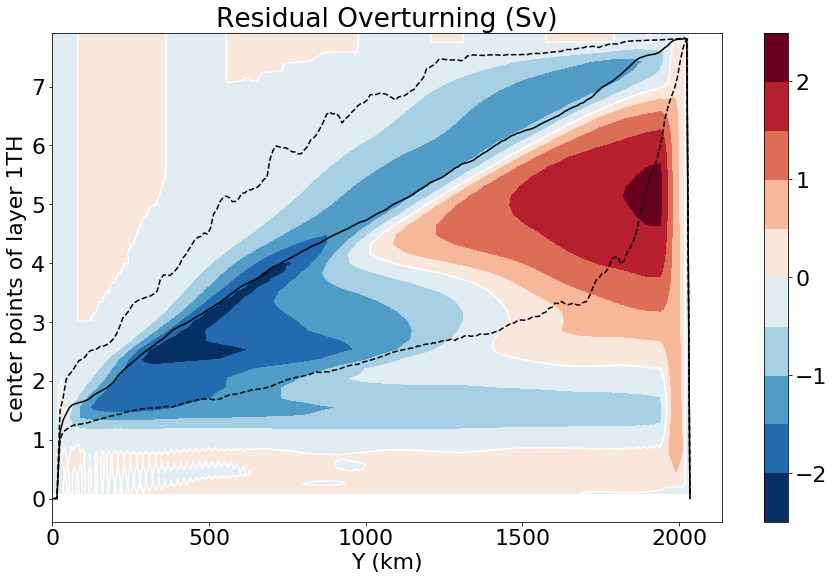

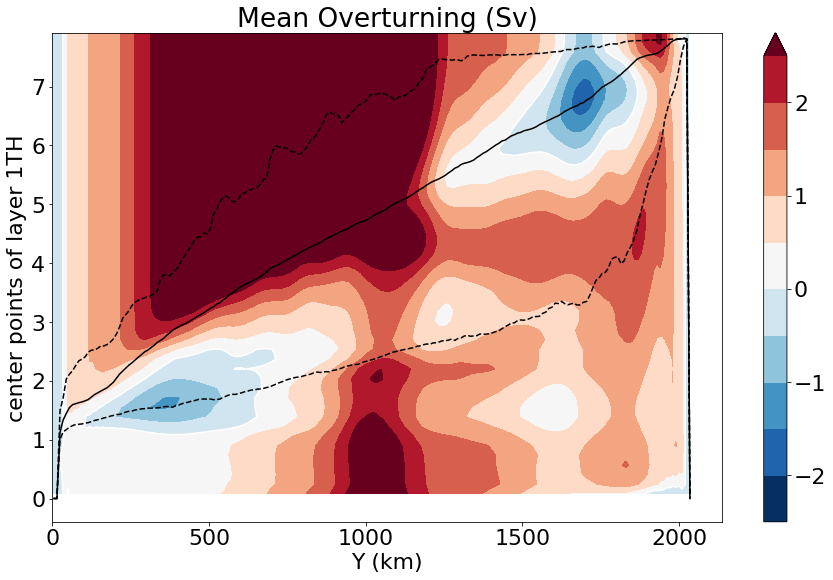

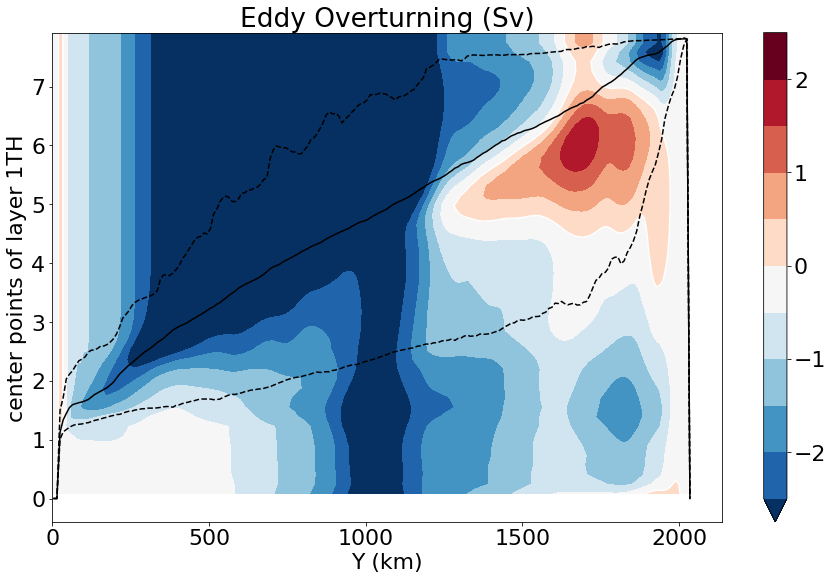

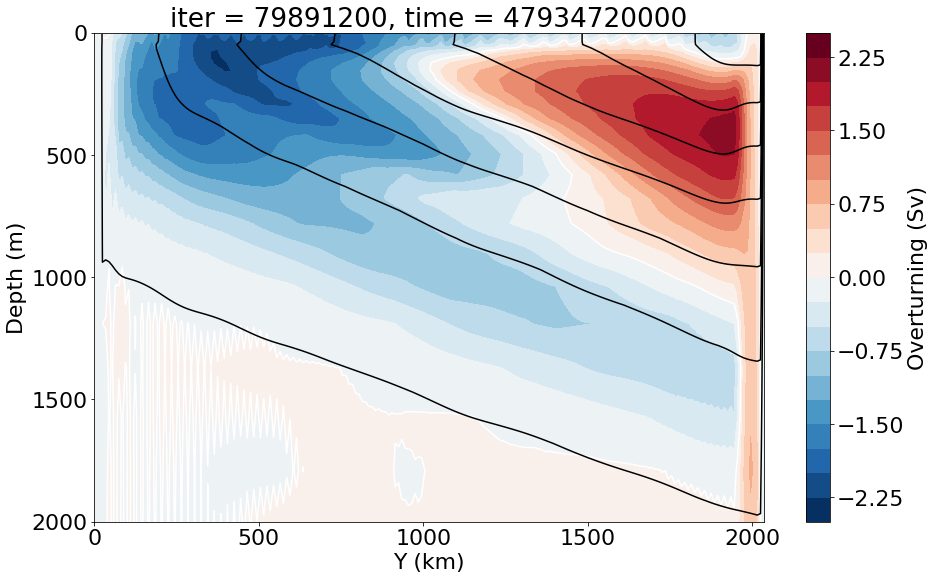

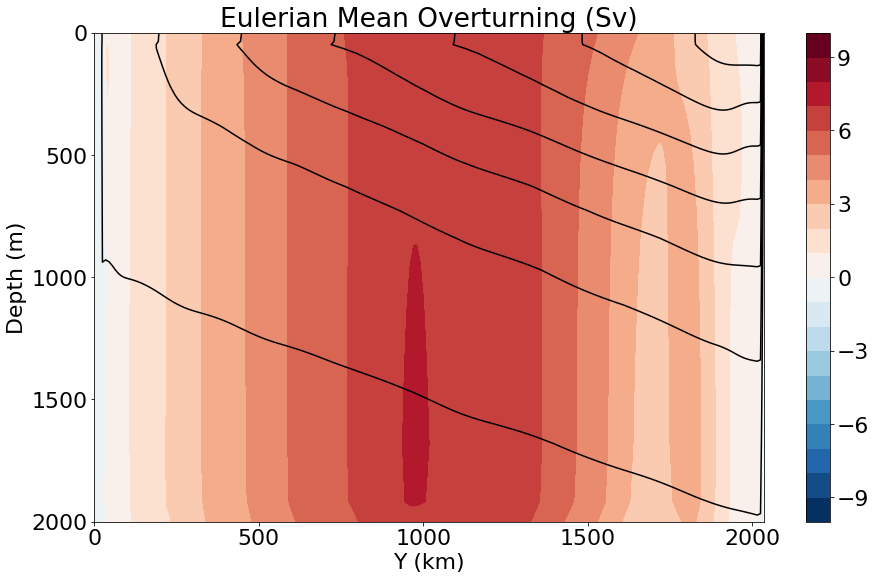

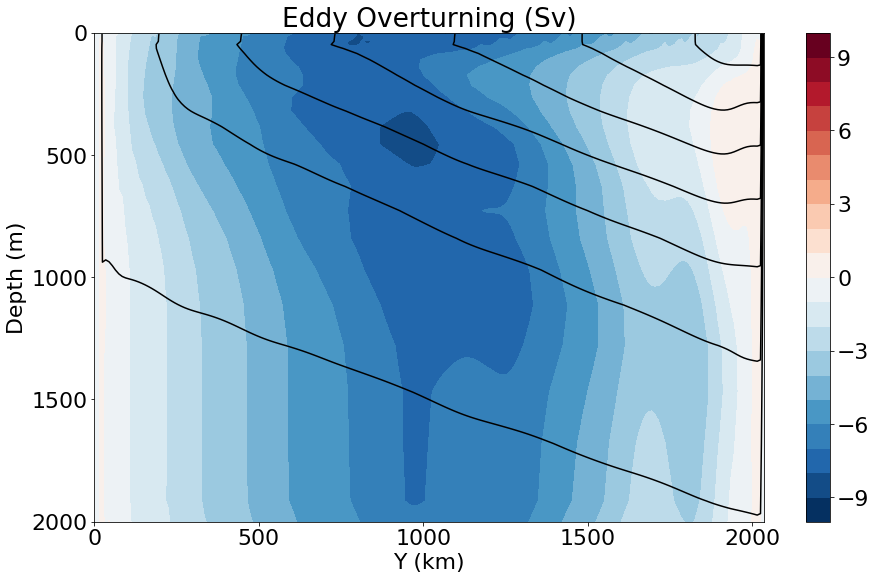

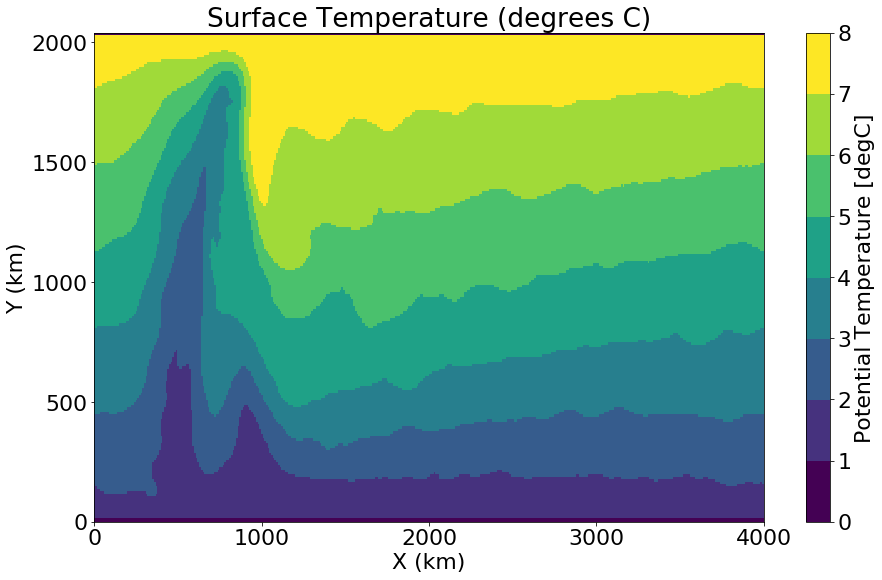

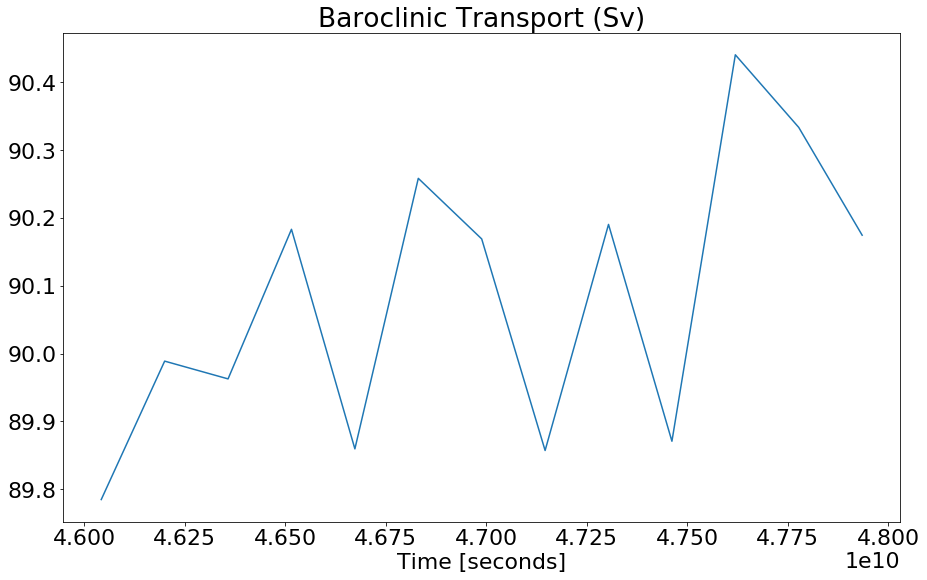

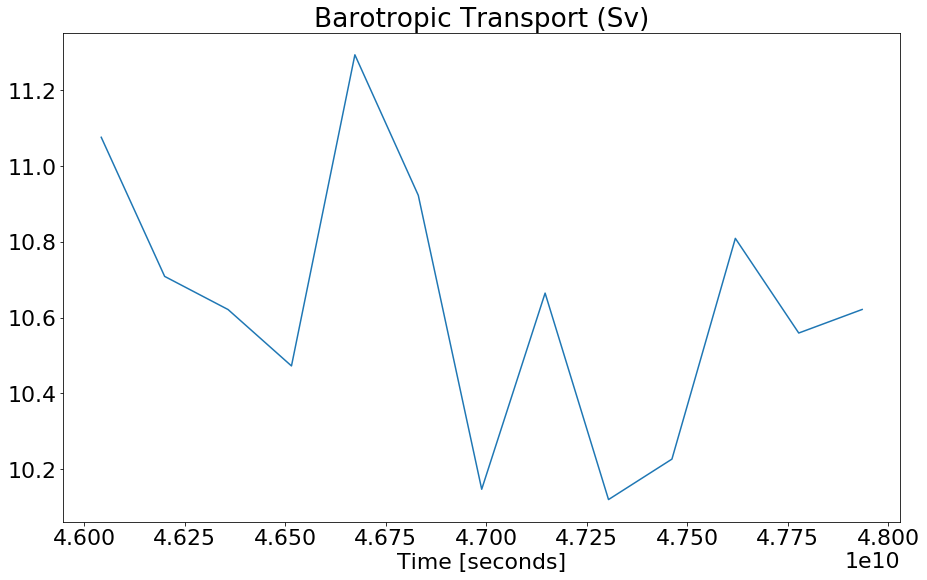

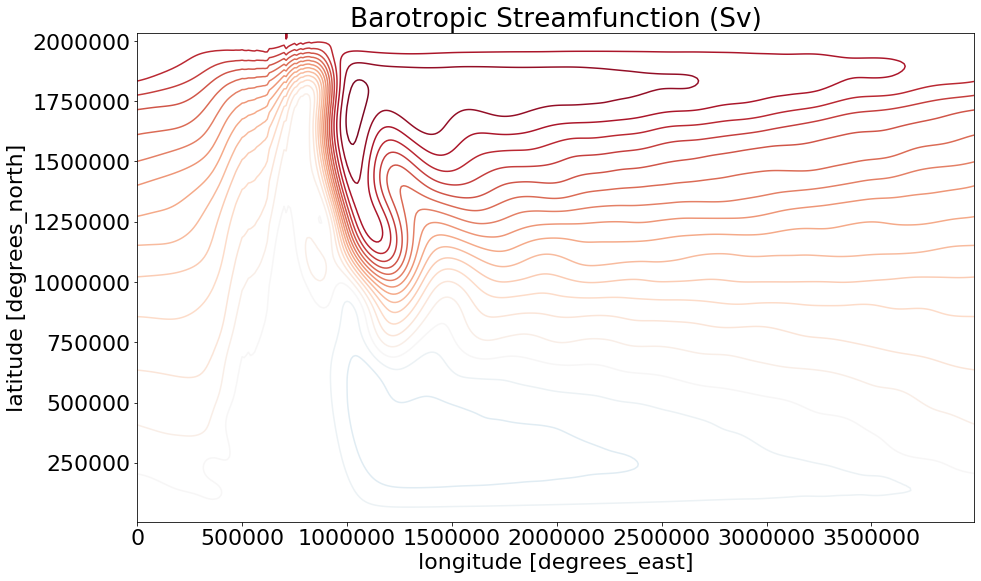

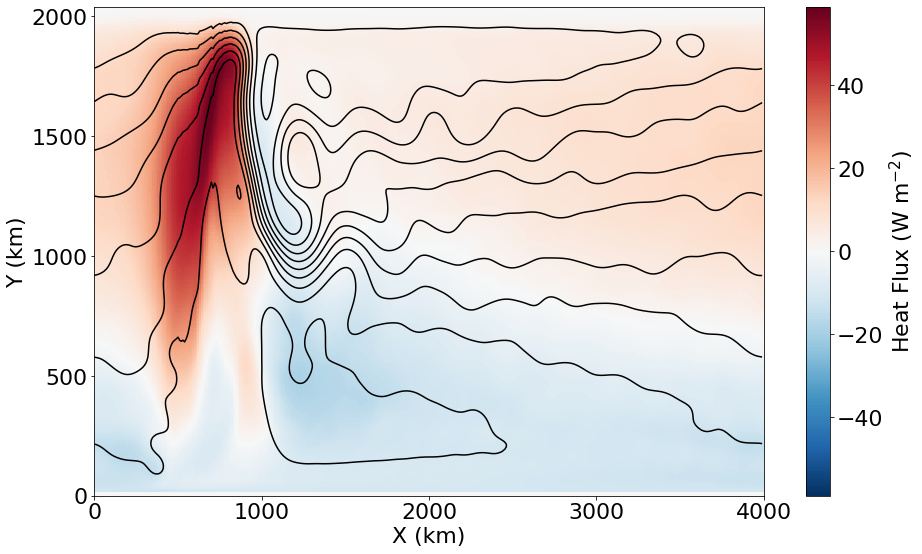

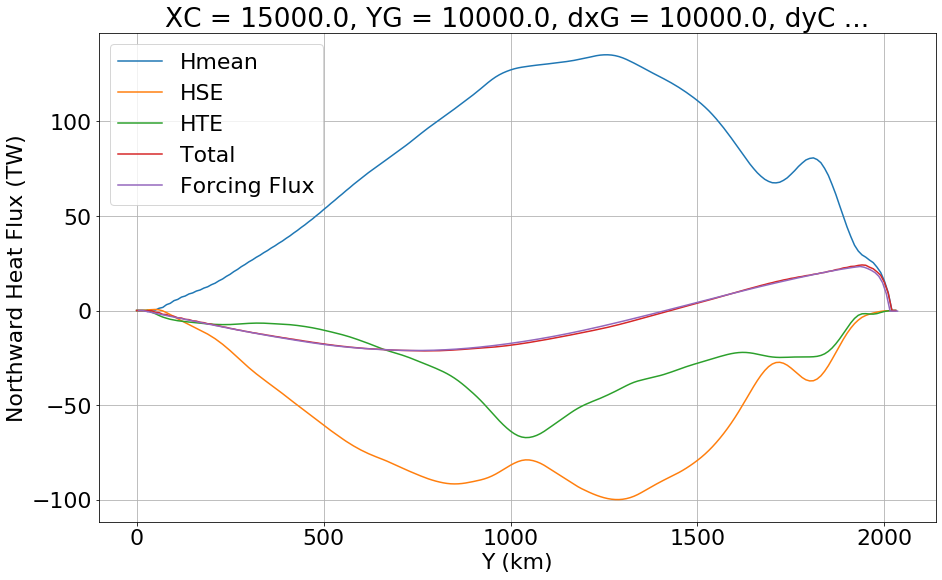

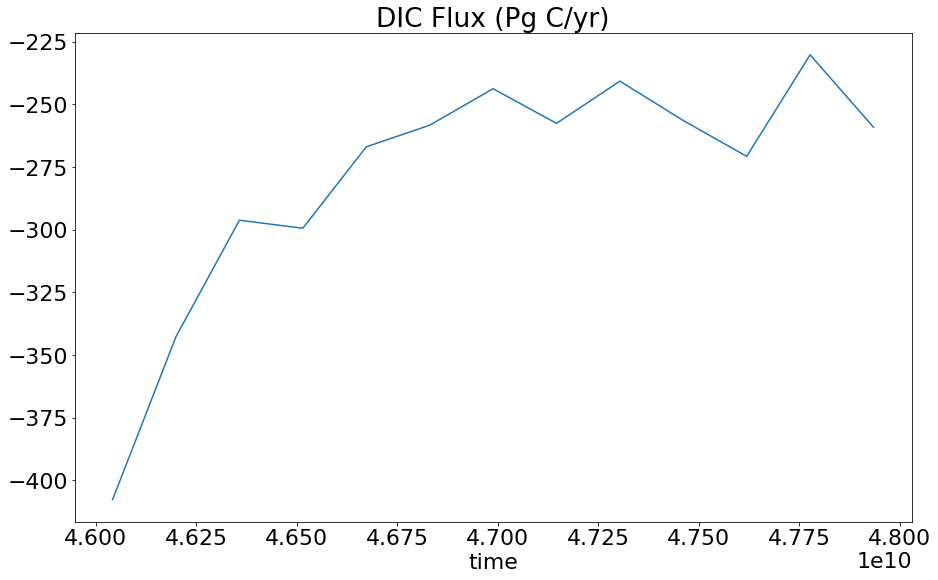

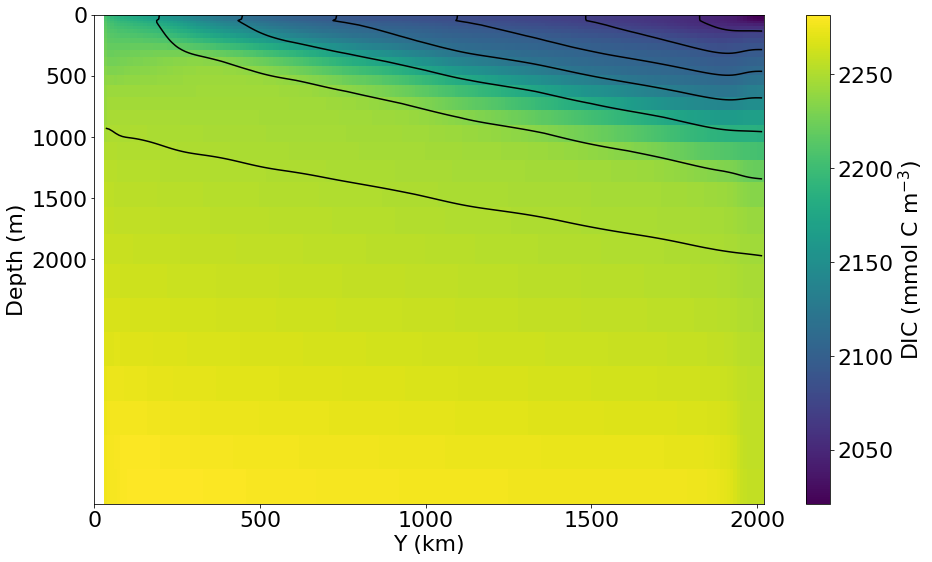

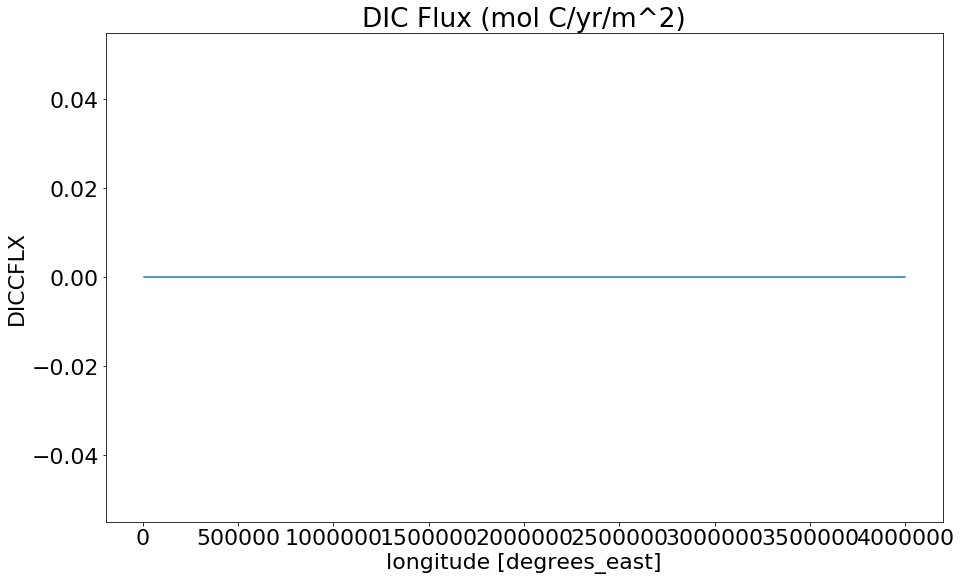

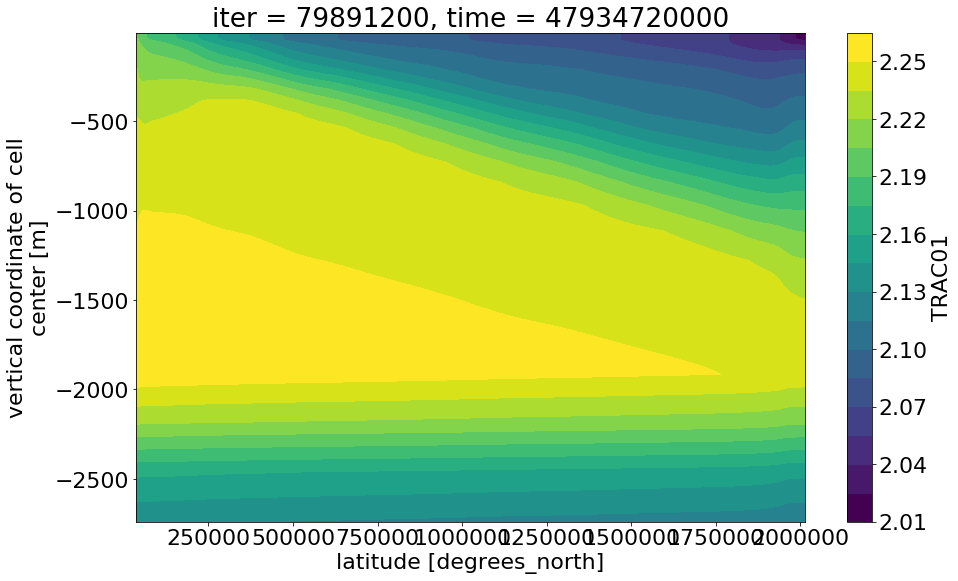

In [3]:
### from pylab import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,9)
plt.rcParams['font.size'] = 22
plt.rcParams['text.usetex'] = False



#series = 'relax'
#run = ['flat0.15relax'] #
#run = ['ridge0.05relax','ridge0.1relax','ridge0.15relax','ridge0.2relax','ridge0.25relax']
#run = ['2xridge0.025x2relax']
#run = ['flat0.05relax','flat0.1relax','flat0.15relax','flat0.2relax','flat0.25relax']
series = 'relax'
#run = ['2xridge0.05oldrelax']#,'ridge0.2flux','flat0.1flux','flat0.2flux']

#run = ['dop_05','dop_1','doppi','dop_2','dop_25']
run = ['dop_mean']

numwinds = 1

year = 8

numruns = len(run)
uppercell = []
lowercell = []
maxtop = []
kappaout = []
slopemean = []
slopemeandown = []
heatfluxout = []
maxwindvec =[]
bcup = []
bcdown = []
meanderheat = []
dicfluxvec = []

plot_dir = '/glade/u/home/myoungs/Figures/'+datetime.date.today().isoformat()+'/'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

for x in run:
    ## read in data #######
    data_dir = '/glade/p/univ/umit0025/newcarbon/'+x
    
    print(data_dir)
    
    if 'dop' in x:
        ds = open_mdsdataset(data_dir,prefix=['DIAG','DIAGLayer','DIAGSurf','DIAGTracer'],delta_t=600)
                        # ignore_unknown_vars==True)#,iters='377225') # ,'DIAGTracer'
    #else:
     #   ds = open_mdsdataset(data_dir,prefix=['DIAG','DIAGLayer','DIAGSurf'],delta_t=600)
    #ds = open_mdsdataset(data_dir,prefix=['DIAGTracer'])
    ds1 = open_mdsdataset(data_dir,prefix=['DIAGInstant'],delta_t = 600)
    #print(ds)
    grid = xgcm.Grid(ds, periodic=['X'])
    #print(grid)
    
    ## calculate overturning ###
    psi = -ds.dxG[0,0]*ds.LaVH1TH.sum(dim='XC').cumsum(dim='layer_1TH_center')/1e6
    psiMean = psi[-year:].mean(dim='time')
    uppercell = np.append(uppercell,psiMean[:-3].max())
    lowercell = np.append(lowercell,-psiMean[0:22,175:200].min())
    maxwind = np.array(ds.oceTAUX[-1,:,1].max(dim='YC'))
    print(maxwind)
    maxwindvec = np.append(maxwindvec,maxwind)
    
    ## calculate mean overturning ##
    #MeanPsi = -ds.dxG[0,0]*(ds.LaVa1TH[-year:].mean(dim='time')*ds.LaHs1TH[-year:].mean(dim='time')).sum(dim='XC').cumsum(dim='layer_1TH_center')/1e6
    
    
    uppercellvec = psi[:,:-3].max(dim=['layer_1TH_center','YG'])
    lowercellvec = -psi[:,0:22,175:200].min(dim=['layer_1TH_center','YG'])
    
    plt.figure()
    uppercellvec.plot()
    lowercellvec.plot()
    
    MeanPsi = -(ds.dxG[0,0]*ds.LaHs1TH.where(ds.LaHs1TH[-year:].mean(dim = 'time') 
            !=0).mean(dim = 'time')*ds.LaVa1TH[-year:].mean(dim = 'time')).cumsum(dim=
            'layer_1TH_center',skipna=True).sum(dim = 'XC')/1e6 
    EddyPsi = psiMean-MeanPsi
    
    ### plot overturning ###
    plt.figure()
    psiMean.plot.contourf(vmin = -2.5, vmax = 2.5, levels = 11,cmap=plt.cm.RdBu_r)
    psiMean.plot.contour(levels = [0],colors = 'w')
    #plt.title('Mean Overturning (Sv)')
    zonaltemp = ds.THETA[-year:].mean(dim='XC').mean(dim='time')
    #zonaltemp[0].plot(color='black')
    #mintemp = ds.THETA[-1:].mean(dim='time').min(dim='XC')
    #mintemp[0].plot(color='black',linestyle='--')
    if len(np.array(ds1.time)) > 4:
        plt.plot(ds.YC,np.percentile(np.append(ds1.THETA[-1,0],np.append(ds1.THETA[-2,0],np.append(ds1.THETA[-3,0],np.append(ds1.THETA[-4,0],ds1.THETA[-5,0],axis=1),axis=1),axis=1),axis=1),1,axis=1),color='black',linestyle='--')
        plt.plot(ds.YC,np.percentile(np.append(ds1.THETA[-1,0],np.append(ds1.THETA[-2,0],np.append(ds1.THETA[-3,0],np.append(ds1.THETA[-4,0],ds1.THETA[-5,0],axis=1),axis=1),axis=1),axis=1),50,axis=1),color='black',linestyle='-')
        plt.plot(ds.YC,np.percentile(np.append(ds1.THETA[-1,0],np.append(ds1.THETA[-2,0],np.append(ds1.THETA[-3,0],np.append(ds1.THETA[-4,0],ds1.THETA[-5,0],axis=1),axis=1),axis=1),axis=1),99,axis=1),color='black',linestyle='--')

    plt.title('Residual Overturning (Sv)')
    plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
    plt.xlabel('Y (km)')
    plt.savefig(plot_dir+'Overturn'+x+'.eps',bbox_inches='tight')
    
    plt.figure()
    MeanPsi.plot.contourf(vmin = -2.5, vmax = 2.5, levels = 11,cmap=plt.cm.RdBu_r)
    MeanPsi.plot.contour(levels = [0],colors = 'w')
    #plt.title('Mean Overturning (Sv)')
    zonaltemp = ds.THETA[-year:].mean(dim='XC').mean(dim='time')
    #zonaltemp[0].plot(color='black')
    #mintemp = ds.THETA[-1:].mean(dim='time').min(dim='XC')
    #mintemp[0].plot(color='black',linestyle='--')
    if len(np.array(ds1.time)) > 4:
        plt.plot(ds.YC,np.percentile(np.append(ds1.THETA[-1,0],np.append(ds1.THETA[-2,0],np.append(ds1.THETA[-3,0],np.append(ds1.THETA[-4,0],ds1.THETA[-5,0],axis=1),axis=1),axis=1),axis=1),1,axis=1),color='black',linestyle='--')
        plt.plot(ds.YC,np.percentile(np.append(ds1.THETA[-1,0],np.append(ds1.THETA[-2,0],np.append(ds1.THETA[-3,0],np.append(ds1.THETA[-4,0],ds1.THETA[-5,0],axis=1),axis=1),axis=1),axis=1),50,axis=1),color='black',linestyle='-')
        plt.plot(ds.YC,np.percentile(np.append(ds1.THETA[-1,0],np.append(ds1.THETA[-2,0],np.append(ds1.THETA[-3,0],np.append(ds1.THETA[-4,0],ds1.THETA[-5,0],axis=1),axis=1),axis=1),axis=1),99,axis=1),color='black',linestyle='--')

    plt.title('Mean Overturning (Sv)')
    plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
    plt.xlabel('Y (km)')
    plt.savefig(plot_dir+'MeanOverturn'+x+'.eps',bbox_inches='tight')
    
    
    plt.figure()

    EddyPsi.plot.contourf(vmin = -2.5, vmax = 2.5, levels = 11,cmap=plt.cm.RdBu_r)
    EddyPsi.plot.contour(levels = [0],colors = 'w')
    #plt.title('Mean Overturning (Sv)')
    zonaltemp = ds.THETA[-year:].mean(dim='XC').mean(dim='time')
    #zonaltemp[0].plot(color='black')
    #mintemp = ds.THETA[-1:].mean(dim='time').min(dim='XC')
    #mintemp[0].plot(color='black',linestyle='--')
    if len(np.array(ds1.time)) > 4:
        plt.plot(ds.YC,np.percentile(np.append(ds1.THETA[-1,0],np.append(ds1.THETA[-2,0],np.append(ds1.THETA[-3,0],np.append(ds1.THETA[-4,0],ds1.THETA[-5,0],axis=1),axis=1),axis=1),axis=1),1,axis=1),color='black',linestyle='--')
        plt.plot(ds.YC,np.percentile(np.append(ds1.THETA[-1,0],np.append(ds1.THETA[-2,0],np.append(ds1.THETA[-3,0],np.append(ds1.THETA[-4,0],ds1.THETA[-5,0],axis=1),axis=1),axis=1),axis=1),50,axis=1),color='black',linestyle='-')
        plt.plot(ds.YC,np.percentile(np.append(ds1.THETA[-1,0],np.append(ds1.THETA[-2,0],np.append(ds1.THETA[-3,0],np.append(ds1.THETA[-4,0],ds1.THETA[-5,0],axis=1),axis=1),axis=1),axis=1),99,axis=1),color='black',linestyle='--')

    plt.title('Eddy Overturning (Sv)')
    plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
    plt.xlabel('Y (km)')
    plt.savefig(plot_dir+'EddyOverturn'+x+'.eps',bbox_inches='tight')
    
    ### plot overturning in Z #####
    [psirho,psiz,kzlay,zklay] = calc_psi_res(ds.LaVH1TH[-year:],ds.THETA[-year:],ds.time[-year:])
    plt.figure()
    (psiz.mean('time')/1e6).plot.contourf(vmin = -2.5, vmax = 2.5, levels = 21,cmap=plt.cm.RdBu_r,cbar_kwargs={'label': 'Overturning (Sv)'})
    psiz.mean('time').plot.contour(levels = [0],colors = 'w')
    plt.ylim((-2000, 0))
    plt.yticks([0,-500,-1000,-1500,-2000],[0,500,1000,1500,2000])
    plt.ylabel('Depth (m)')
    ds.THETA[-1].mean(dim='XC').plot.contour(levels = [1,2,3, 4, 5, 6, 7, 8],colors = 'black')
    #plt.title('Residual Overturning (Sv)')
    plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
    plt.xlabel('Y (km)')
    plt.ylabel('Depth (m)')
    plt.savefig(plot_dir+'OverturnZ'+x+'.eps',bbox_inches='tight')
   
    ### plot eulerian mean overturning ###
    plt.figure()
    psi_em = ((ds.VVELMASS*ds.drF).cumsum(dim = 'Z')*ds.dxG).sum(dim='XC').mean(dim='time')
    (psi_em/1e6).plot.contourf(vmin = -10, vmax = 10, levels = 21,cmap=plt.cm.RdBu_r)
    plt.ylim((-2000, 0))
    plt.yticks([0,-500,-1000,-1500,-2000],[0,500,1000,1500,2000])
    plt.ylabel('Depth (m)')
    ds.THETA[-1].mean(dim='XC').plot.contour(levels = [1,2,3, 4, 5, 6, 7, 8],colors = 'black')
    plt.title('Eulerian Mean Overturning (Sv)')
    plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
    plt.xlabel('Y (km)')
    plt.ylabel('Depth (m)')
    plt.savefig(plot_dir+'EulerianOverturn'+x+'.eps',bbox_inches='tight')
    
    # plot eddy overturning
    plt.figure()
    psieddy = grid.interp(psiz.mean('time'),'Z',boundary='extend')-grid.interp(psi_em,'Y',boundary='extend')
    (psieddy/1e6).plot.contourf(vmin = -10, vmax = 10, levels = 21,cmap=plt.cm.RdBu_r)
    plt.ylim((-2000, 0))
    plt.yticks([0,-500,-1000,-1500,-2000],[0,500,1000,1500,2000])
    plt.ylabel('Depth (m)')
    ds.THETA[-1].mean(dim='XC').plot.contour(levels = [1,2,3, 4, 5, 6, 7, 8],colors = 'black')
    plt.title('Eddy Overturning (Sv)')
    plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
    plt.xlabel('Y (km)')
    plt.ylabel('Depth (m)')
    plt.savefig(plot_dir+'EddyOverturn'+x+'.eps',bbox_inches='tight')
    
    ### plot surface temperature distribution ###
    plt.figure()
    ds.THETA[-1,0].plot(levels=[0,1,2,3, 4, 5, 6, 7, 8])
    plt.xticks([0,1000000,2000000,3000000,4000000],[0,1000,2000,3000,4000])
    plt.xlabel('X (km)')
    plt.yticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
    plt.ylabel('Y (km)')
    plt.title('Surface Temperature (degrees C)')
    plt.savefig(plot_dir+'SurfaceTemp'+x+'.eps',bbox_inches='tight')
    
    

    
    ### calculate and plot zonal transport
    fulltransport = ((ds.UVEL*ds.drF).sum(dim = 'Z')*ds.dyG[0,0]).sum(dim = 'YC').mean(dim='XG')/1e6
    bttransport = (ds.UVEL[:,-1]*4000*ds.dyG[0,0]).sum(dim = 'YC').mean(dim='XG')/1e6
    bctransport = fulltransport-bttransport
    
    plt.figure()
    (bctransport).plot()
    plt.title('Baroclinic Transport (Sv)')
    plt.savefig(plot_dir+'BaroclinicTransport'+x+'.eps')
    
    bttransports = (ds.UVEL[:,-1]*4000*ds.dyG[0,0]).sum(dim = 'YC').mean(dim='XG')/1e6
    plt.figure()
    bttransports.plot()
    plt.title('Barotropic Transport (Sv)')
    plt.savefig(plot_dir+'BarotropicTransport'+x+'.eps')
    
    ### calculate barotropic streamfunction
    plt.figure()
    ((ds.UVEL[:,:-3]*ds.dyG*ds.drF[:-3]/1e6).mean(dim='time').sum(dim='Z').cumsum(dim='YC')).plot.contour(levels = 40)
    plt.title('Barotropic Streamfunction (Sv)')
    plt.savefig(plot_dir+'BarotropicStreamfunction'+x+'.eps')
    
    mask = np.greater(grid.interp(psiz.mean('time'),'Z',boundary='extend'),3e5) # mask postitive
    maskn = np.less(grid.interp(psiz.mean('time'),'Z',boundary='extend'),-3e5)
    maskd = np.less(grid.interp(psiz.mean('time'),'Z',boundary='extend'),3e5)

    dbdy = grid.interp(grid.diff(ds.THETA[-year:].mean(dim=['XC','time']),'Y',boundary = 'extend'),
                          'Y',boundary = 'extend')/ds.dyC[1,1]
    dbdynew = dbdy.where(dbdy !=0)

        
    dbdz = grid.diff(ds.THETA[-year:].mean(dim=['XC','time']),'Z',boundary = 'extend')
    dbdznew = grid.interp(dbdz.where(dbdz !=0),'Z',boundary = 'extend')/ds.drF
    slope = ((((dbdynew[8:,12:-12]/dbdznew[8:,12:-12]*mask[8:,12:-12])*ds.drF[8:]).sum(dim='Z'))/((ds.drF[8:]*mask[8:,12:-12]).sum(dim='Z'))).mean(dim='YC')
    slopedown = ((((dbdynew[8:,12:-12]/dbdznew[8:,12:-12]*maskn[8:,12:-12])*ds.drF[8:]).sum(dim='Z'))/((ds.drF[8:]*maskn[8:,12:-12]).sum(dim='Z'))).mean(dim='YC')
    slopemean = np.append(slopemean,slope)
    slopemeandown = np.append(slopemeandown,slopedown)
    ### calculate and plot total heat flux ###
   
    ### plot surface temperature distribution ###
    plt.figure()
    (ds.TRELAX[-year:].mean(dim = ['time'])).plot(cbar_kwargs={'label': 'Heat Flux (W m$^{-2}$)'})
    ((ds.UVEL[-1,:-3]*ds.dyG*ds.drF[:-3]/1e6).sum(dim='Z').cumsum(dim='YC')).plot.contour(levels = 20,colors = 'black',linewidth=1,linestyles='solid')
    plt.xticks([0,1000000,2000000,3000000,4000000],[0,1000,2000,3000,4000])
    plt.xlabel('X (km)')
    plt.yticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
    plt.ylabel('Y (km)')
    plt.title('')
    #plt.title('Surface Heat Flux (W m^{-2})')
    plt.savefig(plot_dir+'SurfaceHF'+x+'.eps',bbox_inches='tight')


    ### plot heat flux profile ###
    if 'relax' in x:
        plt.figure()
        (ds.TRELAX[-year:].mean(dim = ['XC','time'])).plot()
        heatfluxout = np.append(heatfluxout,ds.TRELAX[-year:].mean(dim = ['XC','time']))
        outlat = np.interp(ds.THETA[-4:,:,196].mean(dim=['XC','time']),ds.THETA[-4:,0,2:202].mean(dim=['XC','time']),ds.YC[2:202])
        plt.plot(outlat,-(1e3*4e3*ds.gT_Forc[-4:,:,196].mean(dim=['XC','time'])*ds.drF))
        plt.title('Heat Flux (W/m^2)')
        plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
        plt.legend(['Surface Flux','Northern Boundary Flux'])
        plt.xlabel('Y (km)')
        plt.ylabel('Heat Flux (W/m^2)')
        plt.grid()
        plt.plot(np.zeros(2000000),'b--')
        plt.ylim((-25,25))
        plt.savefig(plot_dir+'HFLat'+x+'.eps',bbox_inches='tight')
        
        f = interpolate.interp1d(outlat, -(1e3*4e3*ds.gT_Forc[-4:,:,196].mean(dim=['XC','time'])*ds.drF),fill_value='extrapolate')
        nbflux = f(ds.YG)
        
        meanderheat = np.append(meanderheat,nbflux-(ds.TRELAX[-year:].mean(dim = ['XC','time'])))

        
    
    
    ### plot heat flux ###
    

    Hmean = 1e3*4e6*4e3/1e12*((ds.VVEL[-year:].where(ds.VVEL[-year:]!=0)).mean(dim = ['XC','time'])*(grid.interp(ds.THETA[-year:],
                                                'Y',boundary = 'extend').where(ds.VVEL[-year:]!=0)*ds.drF).mean(dim=['XC','time'])).sum(dim = 'Z')

    Htimemean = 1e3*4e6*4e3/1e12*((ds.VVEL[-year:]*grid.interp(ds.THETA[-year:],
                                'Y',boundary = 'extend')*ds.drF).where(ds.VVEL[-year:]!=0)).mean(dim = ['XC','time']).sum(dim = 'Z')
    HSE = Htimemean - Hmean

    HTE = 1e3*4e6*4e3/1e12*((ds.VVELTH[-year:]*ds.drF).where(ds.VVEL[-year:]!=0)).mean(dim = ['XC','time']).sum(dim = 'Z') - Htimemean

    gTflux = 1e3*ds.dxG[1,1]*ds.dyG[1,1]*4e3/1e12*(ds.gT_Forc[-year:]*ds.drF).mean(dim='time').sum(dim = ['Z','XC']).cumsum(dim='YC')

 
    
    plt.figure()
    Hmean.plot()
    HSE.plot()
    HTE.plot()
    (Hmean+HSE+HTE).plot()
    gTflux.plot()
    plt.legend(['Hmean','HSE','HTE','Total','Forcing Flux'])
    plt.ylabel('Northward Heat Flux (TW)')
    plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
    plt.xlabel('Y (km)')
    plt.grid()
    plt.savefig(plot_dir+'HeatFlux'+x+'.eps')
    
    if 'dop' in x:
            ### calculate DIC Flux ###
        flux = ds.DICCFLX
        plt.figure()
        (flux.sum(dim = 'XC').sum(dim = 'YC')*12*3600*24*365/1e15*1000*ds.dyG[0,0]*ds.dxG[0,0]*10).plot()
        plt.title('DIC Flux (Pg C/yr)')
        plt.xlabel('time')
        plt.savefig(plot_dir+'DIC'+x+'.eps')

        plt.figure()
        c = (1000*ds.TRAC01[:,:,3:-2].mean(dim='time').where(ds.TRAC01[-1,:,3:-2]!=0).mean(dim='XC')).plot(cbar_kwargs={'label': 'DIC (mmol C m$^{-3}$)'})
        ds.THETA[-1,:,3:-2].mean(dim='XC').plot.contour(levels = [0,1,2,3, 4, 5, 6, 7, 8],colors = 'black')
        plt.ylabel('Depth (m)')
        plt.yticks([-2000,-1500,-1000,-500,0],[2000,1500,1000,500,0])
        plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
        plt.title('')
        plt.xlabel('Y (km)')
        plt.savefig(plot_dir+'NormalDICAve'+x+'.eps',bbox_inches='tight')
        
        plt.figure()
        (ds.DICCFLX[-1,0]*3600*24*365*1000*10).plot()
        plt.title('DIC Flux (mol C/yr/m^2)')
        plt.savefig(plot_dir+'DICFlux'+x+'.eps')
        
        plt.figure()
        1e6*ds.TRAC01[-1,:-4,3:-2].mean(dim='XC').plot.contourf(levels=21)#(vmin = -0.3, vmax = 0.3, levels = 21,cmap=plt.cm.RdBu_r)
        ds.THETA[-1,:-4,3:-2].mean(dim='XC').plot.contour(levels = [0,1,2,3, 4, 5, 6, 7, 8],colors = 'black')
        plt.title('DIC (mol/kg)')
        plt.savefig(plot_dir+'NormalDICAve'+x+'.eps',bbox_inches='tight')
        
    if 'dop' in x:
        plt.plot(ds.DICCFLX[:,:,3:-2].mean(dim=['XC','YC']))
        plt.savefig(plot_dir+'MeanCO2Flux'+x+'.eps')
        dicfluxvec = np.append(dicfluxvec,ds.DICCFLX[:,:,3:-2].mean(dim = ['XC','YC','time']))
        
        fig, ax = plt.subplots()
        (ds.DICCFLX[-1,3:-2]*-3.15e7).plot(cbar_kwargs={'label': 'Air-Sea CO$_2$ Flux (mol C m$^{-2}$s$^{-1}$)'})
        ((ds.UVEL[-1,:-3]*ds.dyG*ds.drF[:-3]/1e6).sum(dim='Z').cumsum(dim='YC')).plot.contour(levels = 20,colors = 'black',linewidth=1)
        plt.title('')
        plt.yticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
        plt.ylabel('Y (km)')
        plt.xticks([0,500000,1000000,1500000,2000000,2500000,3000000,3500000,4000000],[0,500,1000,1500,2000,2500,3000,3500,4000])
        plt.xlabel('X (km)')

#rect = plt.Rectangle((400000, 500000), 800000, 1000000,
#                    edgecolor='k',linewidth=3,facecolor='none')
#rect2 = plt.Rectangle((3000000, 500000), 800000, 1000000,
#                    edgecolor='k',linewidth=3,facecolor='none')
#ax.add_patch(rect)
#ax.add_patch(rect2)

        plt.savefig(plot_dir+'CO2Flux'+x+'.eps')

In [ ]:
ds

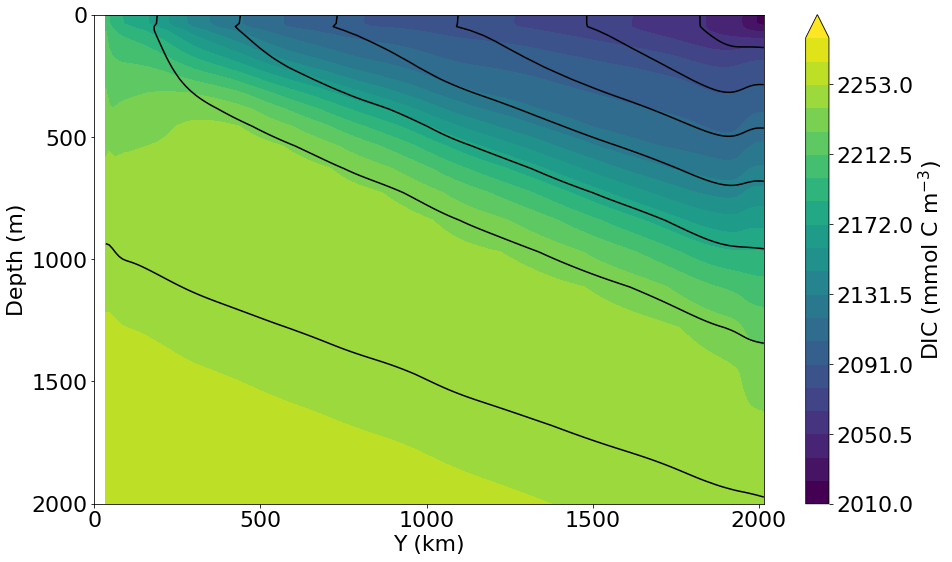

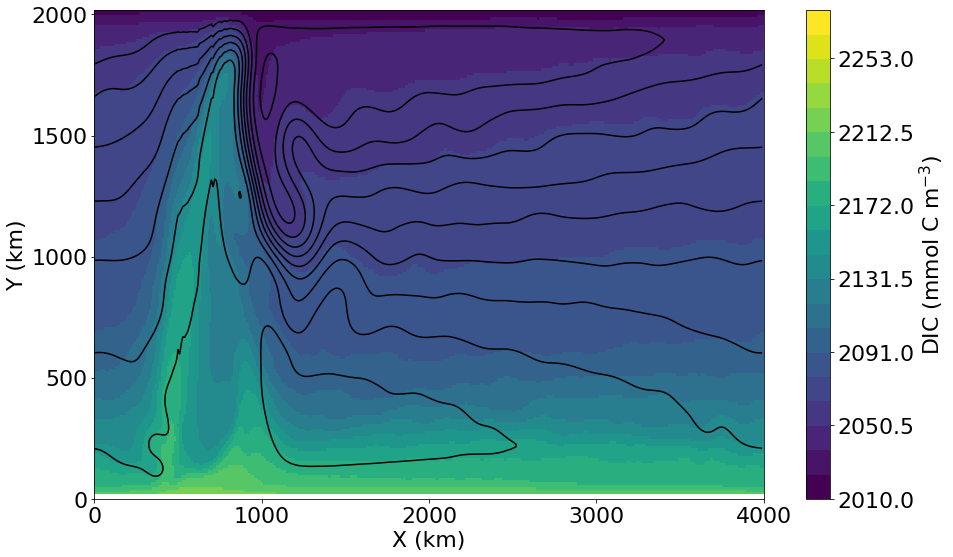

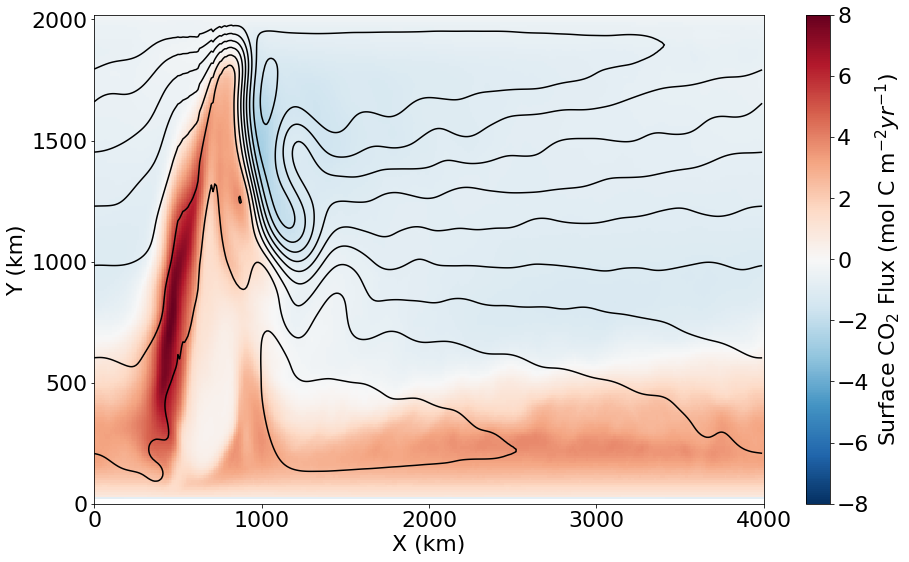

In [8]:
plt.figure()
c = (1000*ds.TRAC01[-4:,:,2:-2].mean(dim='time').where(ds.TRAC01[-1,:,3:-2]!=0).mean(dim='XC')).plot.contourf(vmin=2010,vmax=2280,levels=21,cbar_kwargs={'label': 'DIC (mmol C m$^{-3}$)'})
ds.THETA[:,:,3:-2].mean(dim=['XC','time']).plot.contour(levels = [0,1,2,3, 4, 5, 6, 7, 8],colors = 'black')
plt.ylabel('Depth (m)')
plt.yticks([-2000,-1500,-1000,-500,0],[2000,1500,1000,500,0])
plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.title('')
plt.xlabel('Y (km)')
plt.ylim([-2000, 0])

plt.savefig(plot_dir+'NormalDICAve'+x+'.eps',bbox_inches='tight')

plt.figure()
(1000*ds.TRAC01[-4:,0,2:-2]).mean(dim='time').plot(cbar_kwargs={'label': 'DIC (mmol C m$^{-3}$)'},vmin=2010,vmax=2280,levels=21)
((ds.UVEL[-4:,:-3].mean(dim='time')*ds.dyG*ds.drF[:-3]/1e6).sum(dim='Z').cumsum(dim='YC')).plot.contour(levels = 20,colors = 'black',linewidth=1,linestyles='solid')
plt.title('')
plt.yticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.ylabel('Y (km)')
plt.xticks([0,1000000,2000000,3000000,4000000],[0,1000,2000,3000,4000])
plt.xlabel('X (km)')
plt.savefig(plot_dir+'SurfDIC'+x+'.eps',bbox_inches='tight')


fig, ax = plt.subplots()
(-3600*24*360*ds.DICCFLX[-4:,2:-2].mean(dim='time')).plot(cbar_kwargs={'label': 'Surface CO$_2$ Flux (mol C m$^{-2} yr^{-1}$)'})
((ds.UVEL[-4:,:-3].mean(dim='time')*ds.dyG*ds.drF[:-3]/1e6).sum(dim='Z').cumsum(dim='YC')).plot.contour(levels = 20,colors = 'black',linewidth=1,linestyles='solid')
plt.title('')
plt.yticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.ylabel('Y (km)')
plt.xticks([0,1000000,2000000,3000000,4000000],[0,1000,2000,3000,4000])
plt.xlabel('X (km)')

plt.savefig(plot_dir+'CO2Flux'+x+'.eps')




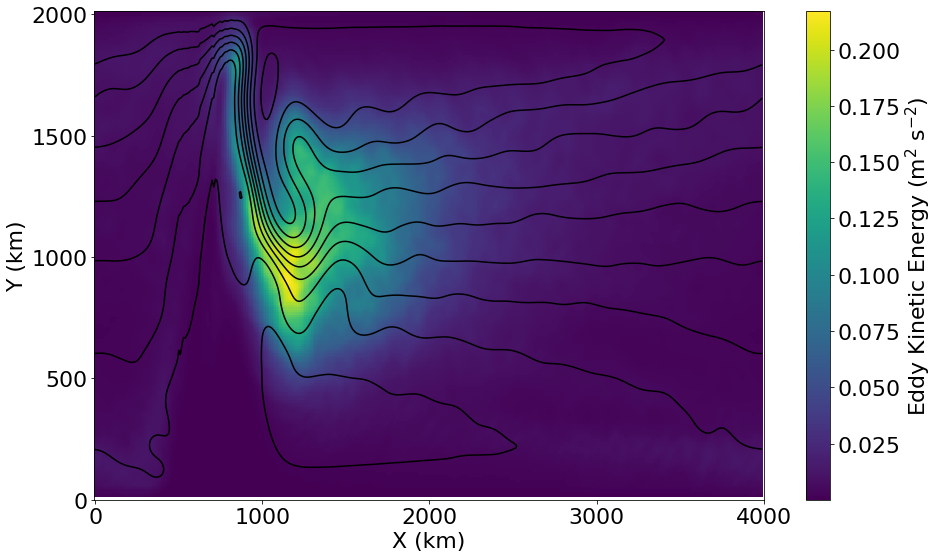

In [5]:
fig, ax = plt.subplots()

EKE = 1/2*(grid.interp(ds.VVELSQ[-4:].mean(dim='time') - ds.VVEL[-4:].mean(dim='time')*ds.VVEL[-4:].mean(dim='time'),'X') + grid.interp(ds.UVELSQ[-4:].mean(dim='time') - ds.UVEL[-4:].mean(dim='time')*ds.UVEL[-4:].mean(dim='time'),'Y',boundary='extend'))
EKE[0,2:-2].plot(cbar_kwargs={'label': 'Eddy Kinetic Energy (m$^2$ s$^{-2}$)'})
((ds.UVEL[-4:,:-3].mean(dim='time')*ds.dyG*ds.drF[:-3]/1e6).sum(dim='Z').cumsum(dim='YC')).plot.contour(levels = 20,colors = 'black',linewidth=1,linestyles='solid')
plt.title('')
plt.yticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.ylabel('Y (km)')
plt.xticks([0,1000000,2000000,3000000,4000000],[0,1000,2000,3000,4000])
plt.xlabel('X (km)')

plt.savefig(plot_dir+'EKE'+x+'.eps')

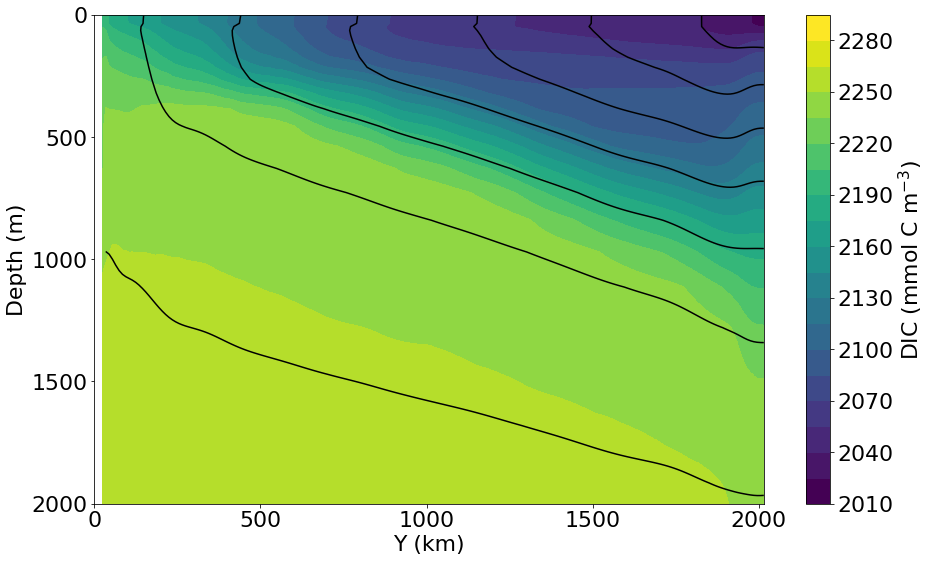

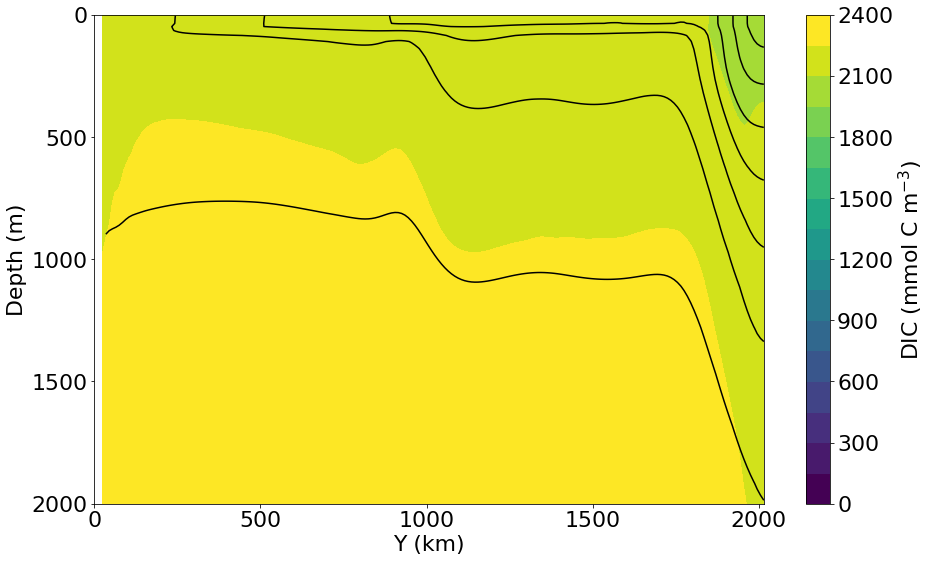

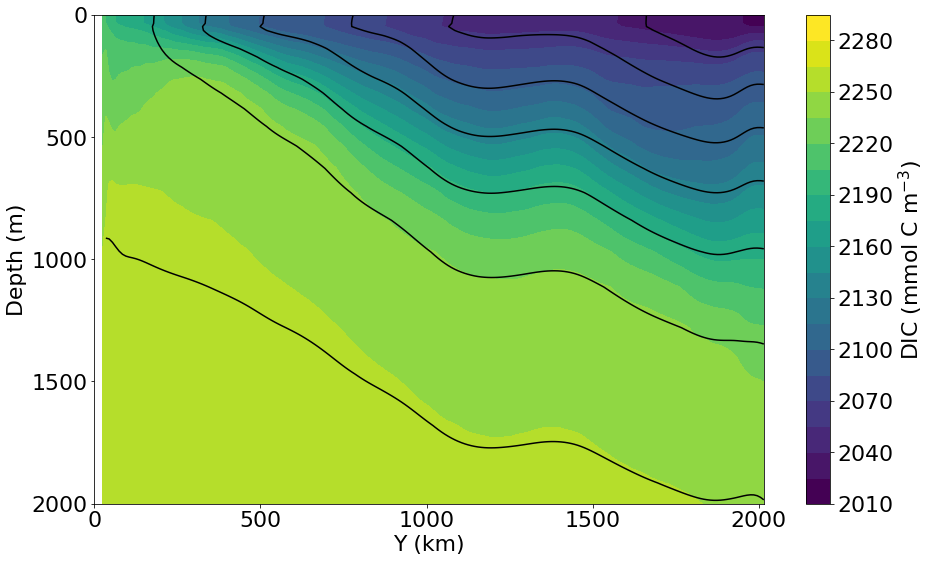

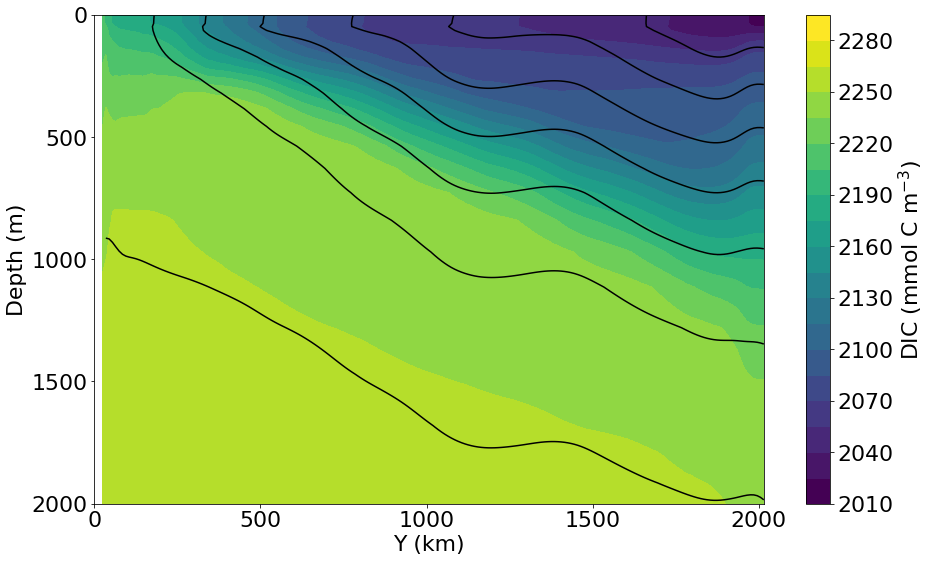

In [10]:
plt.figure()
c = (1000*ds.TRAC01[-4:,:,2:-2,0].mean(dim='time')).plot.contourf(levels=21,cbar_kwargs={'label': 'DIC (mmol C m$^{-3}$)'})
ds.THETA[:,:,3:-2,0].mean(dim=['time']).plot.contour(levels = [0,1,2,3, 4, 5, 6, 7, 8],colors = 'black')
plt.ylabel('Depth (m)')
plt.yticks([-2000,-1500,-1000,-500,0],[2000,1500,1000,500,0])
plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.title('')
plt.xlabel('Y (km)')
plt.ylim([-2000, 0])

plt.savefig(plot_dir+'UpstreamDIC'+x+'.eps',bbox_inches='tight')

plt.figure()
c = (1000*ds.TRAC01[-4:,:,2:-2,80].mean(dim='time')).plot.contourf(levels=21,cbar_kwargs={'label': 'DIC (mmol C m$^{-3}$)'})
ds.THETA[:,:,3:-2,80].mean(dim=['time']).plot.contour(levels = [0,1,2,3, 4, 5, 6, 7, 8],colors = 'black')
plt.ylabel('Depth (m)')
plt.yticks([-2000,-1500,-1000,-500,0],[2000,1500,1000,500,0])
plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.title('')
plt.xlabel('Y (km)')
plt.ylim([-2000, 0])

plt.savefig(plot_dir+'TopOfRidgeDIC'+x+'.eps',bbox_inches='tight')

plt.figure()
c = (1000*ds.TRAC01[-4:,:,2:-2,120].mean(dim='time')).plot.contourf(levels=21,cbar_kwargs={'label': 'DIC (mmol C m$^{-3}$)'})
ds.THETA[:,:,3:-2,120].mean(dim=['time']).plot.contour(levels = [0,1,2,3, 4, 5, 6, 7, 8],colors = 'black')
plt.ylabel('Depth (m)')
plt.yticks([-2000,-1500,-1000,-500,0],[2000,1500,1000,500,0])
plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.title('')
plt.xlabel('Y (km)')
plt.ylim([-2000, 0])

plt.savefig(plot_dir+'TurbulentRegionDIC'+x+'.eps',bbox_inches='tight')

plt.figure()
c = (1000*ds.TRAC01[-4:,:,2:-2,300].mean(dim='time')).plot.contourf(levels=21,cbar_kwargs={'label': 'DIC (mmol C m$^{-3}$)'})
ds.THETA[:,:,3:-2,120].mean(dim=['time']).plot.contour(levels = [0,1,2,3, 4, 5, 6, 7, 8],colors = 'black')
plt.ylabel('Depth (m)')
plt.yticks([-2000,-1500,-1000,-500,0],[2000,1500,1000,500,0])
plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.title('')
plt.xlabel('Y (km)')
plt.ylim([-2000, 0])

plt.savefig(plot_dir+'DownstreamDIC'+x+'.eps',bbox_inches='tight')

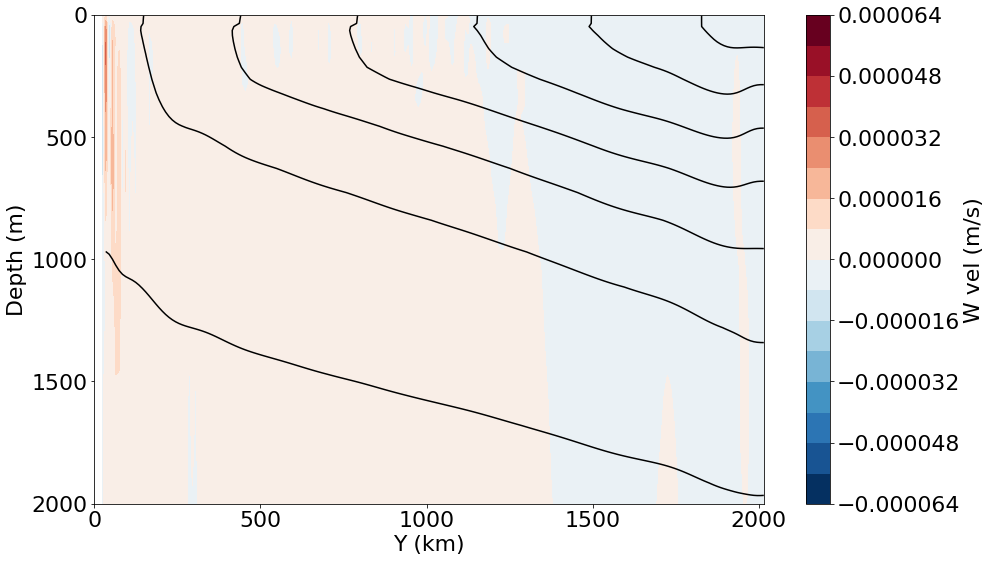

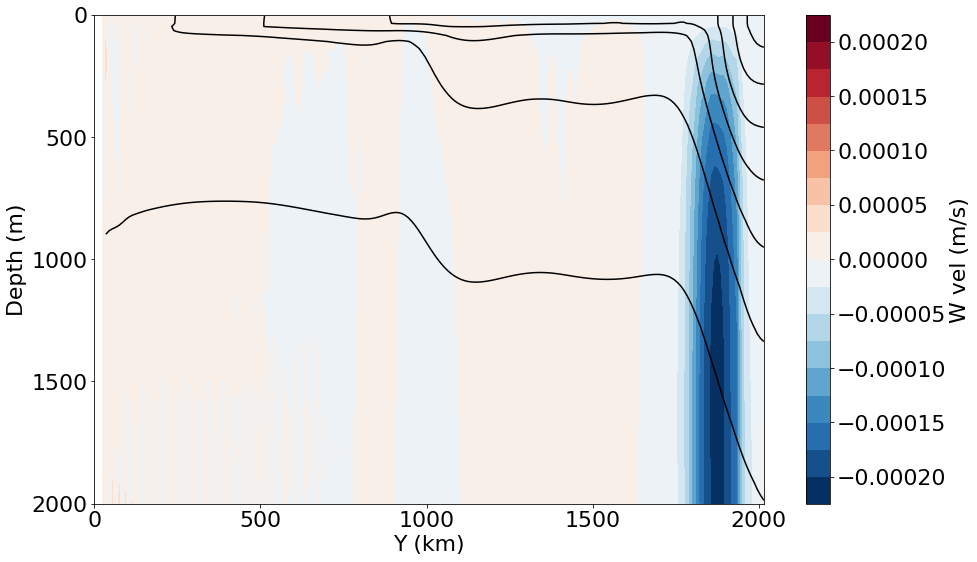

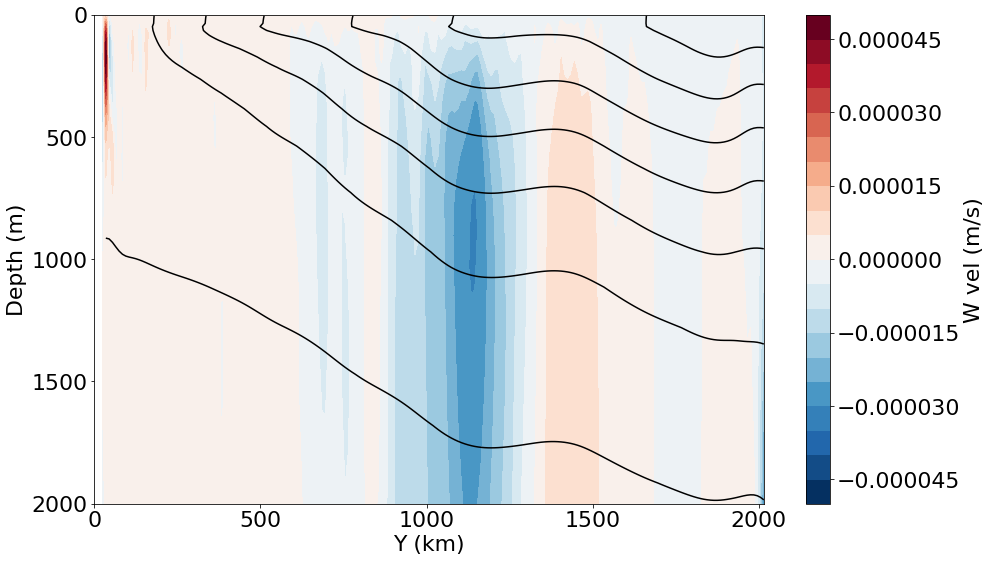

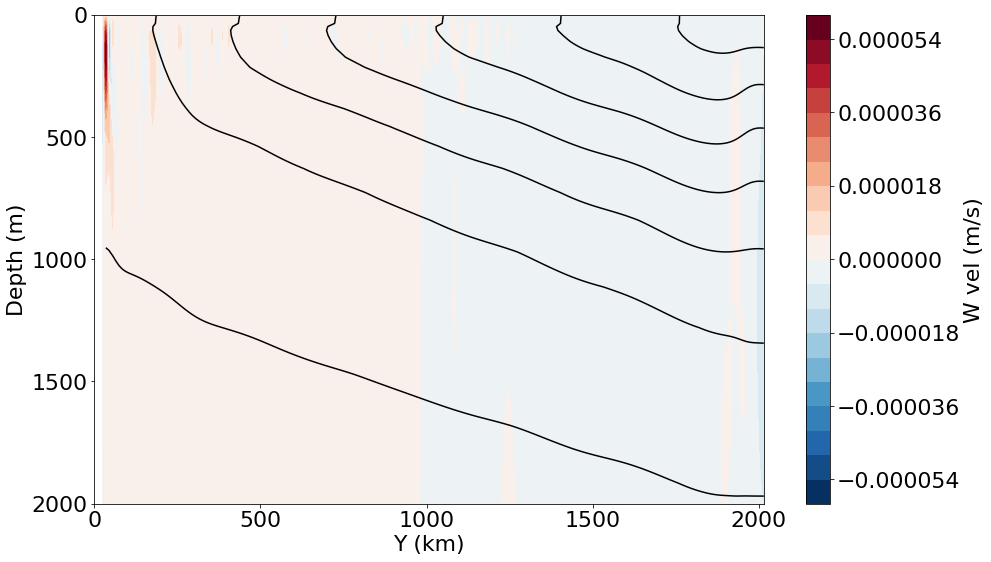

In [11]:
plt.figure()
c = (ds.WVEL[-4:,:,2:-2,0].mean(dim='time')).plot.contourf(levels=21,cbar_kwargs={'label': 'W vel (m/s)'})
ds.THETA[:,:,3:-2,0].mean(dim=['time']).plot.contour(levels = [0,1,2,3, 4, 5, 6, 7, 8],colors = 'black')
plt.ylabel('Depth (m)')
plt.yticks([-2000,-1500,-1000,-500,0],[2000,1500,1000,500,0])
plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.title('')
plt.xlabel('Y (km)')
plt.ylim([-2000, 0])

plt.savefig(plot_dir+'UpstreamW'+x+'.eps',bbox_inches='tight')

plt.figure()
c = (ds.WVEL[-4:,:,2:-2,80].mean(dim='time')).plot.contourf(levels=21,cbar_kwargs={'label': 'W vel (m/s)'})
ds.THETA[:,:,3:-2,80].mean(dim=['time']).plot.contour(levels = [0,1,2,3, 4, 5, 6, 7, 8],colors = 'black')
plt.ylabel('Depth (m)')
plt.yticks([-2000,-1500,-1000,-500,0],[2000,1500,1000,500,0])
plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.title('')
plt.xlabel('Y (km)')
plt.ylim([-2000, 0])

plt.savefig(plot_dir+'TopOfRidgeW'+x+'.eps',bbox_inches='tight')

plt.figure()
c = (ds.WVEL[-4:,:,2:-2,120].mean(dim='time')).plot.contourf(levels=21,cbar_kwargs={'label': 'W vel (m/s)'})
ds.THETA[:,:,3:-2,120].mean(dim=['time']).plot.contour(levels = [0,1,2,3, 4, 5, 6, 7, 8],colors = 'black')
plt.ylabel('Depth (m)')
plt.yticks([-2000,-1500,-1000,-500,0],[2000,1500,1000,500,0])
plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.title('')
plt.xlabel('Y (km)')
plt.ylim([-2000, 0])

plt.savefig(plot_dir+'TurbulentRegionW'+x+'.eps',bbox_inches='tight')

plt.figure()
c = (ds.WVEL[-4:,:,2:-2,300].mean(dim='time')).plot.contourf(levels=21,cbar_kwargs={'label': 'W vel (m/s)'})
ds.THETA[:,:,3:-2,300].mean(dim=['time']).plot.contour(levels = [0,1,2,3, 4, 5, 6, 7, 8],colors = 'black')
plt.ylabel('Depth (m)')
plt.yticks([-2000,-1500,-1000,-500,0],[2000,1500,1000,500,0])
plt.xticks([0,500000,1000000,1500000,2000000],[0,500,1000,1500,2000])
plt.title('')
plt.xlabel('Y (km)')
plt.ylim([-2000, 0])

plt.savefig(plot_dir+'DownstreamW'+x+'.eps',bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0.87555254 1.58151484 2.09949136 2.54448128 2.90722609]
[0.67202312 0.81377995 0.83774114 0.8280015  0.75205845]


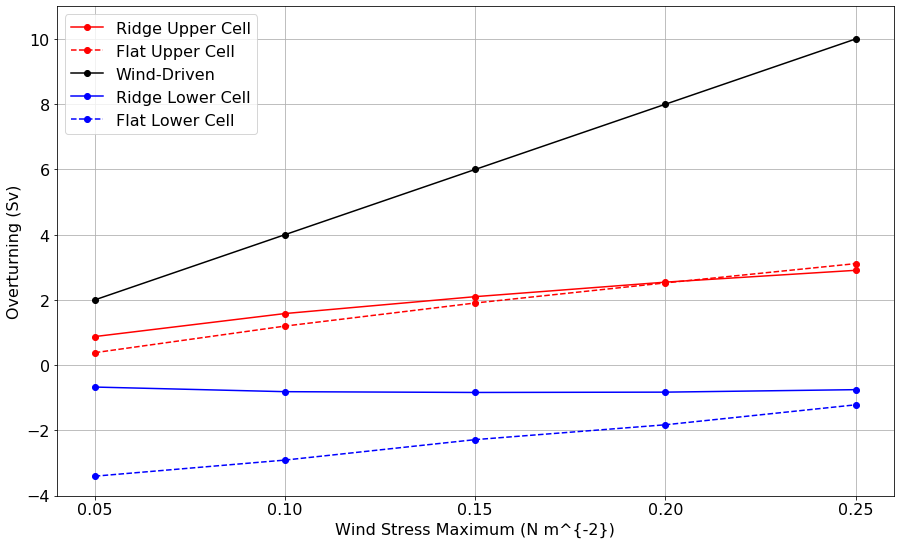

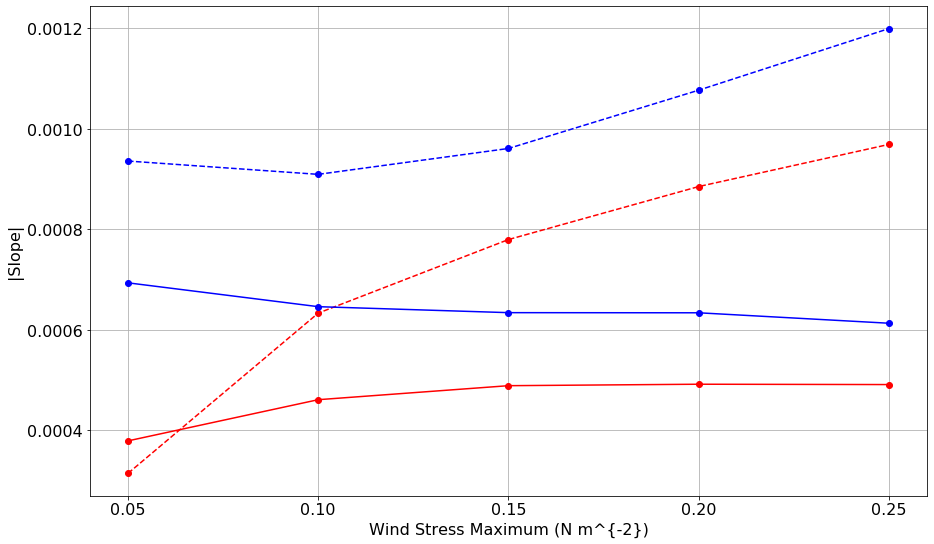

In [8]:
#uppercellflat = uppercell
#lowercellflat = lowercell
#slopemeanflat = slopemean
#slopemeandownflat = slopemeandown
numwinds = 5

### plot overturning vs wind stress ###
plt.figure()
plt.plot(maxwindvec[0:numwinds],uppercell[0:numwinds],'o-r')
plt.plot(maxwindvec[0:numwinds],uppercellflat[0:numwinds],'o--r')
#plt.plot(maxwindvec[3:],uppercell[3:],'--r')
plt.plot(maxwindvec[0:numwinds],(maxwindvec[0:numwinds])*40,'o-k')
plt.plot(maxwindvec[0:numwinds],-lowercell[0:numwinds],'o-b')
plt.plot(maxwindvec[0:numwinds],-lowercellflat[0:numwinds],'o--b')
#plt.plot(maxwindvec[3:],-lowercell[3:],'--b')
#plt.ylim((-2.4, 2.4))
plt.ylim((-4,11))
plt.xticks([0.05, 0.1, 0.15, 0.2, 0.25])
plt.grid()
plt.xlabel('Wind Stress Maximum (N m^{-2})')
plt.legend(['Ridge Upper Cell','Flat Upper Cell','Wind-Driven','Ridge Lower Cell','Flat Lower Cell'])
plt.ylabel('Overturning (Sv)')
plt.savefig(plot_dir+'Strength'+series+'.eps')



### plot overturning vs wind stress ###
plt.figure()
plt.plot(maxwindvec[0:numwinds],-slopemean[0:numwinds],'o-r')
plt.plot(maxwindvec[0:numwinds],-slopemeanflat[0:numwinds],'o--r')
#plt.plot(maxwindvec[3:],uppercell[3:],'--r')
#plt.plot(maxwindvec[0:numwinds],(maxwindvec[0:numwinds])*40,'o-k')
plt.plot(maxwindvec[0:numwinds],-slopemeandown[0:numwinds],'o-b')
plt.plot(maxwindvec[0:numwinds],-slopemeandownflat[0:numwinds],'o--b')
#plt.plot(maxwindvec[3:],-lowercell[3:],'--b')
#plt.ylim((-2.4, 2.4))
#plt.ylim((-4,10))
plt.xticks([0.05, 0.1, 0.15, 0.2, 0.25])
plt.grid()
plt.xlabel('Wind Stress Maximum (N m^{-2})')
#plt.legend(['Ridge Upper Cell','Flat Upper Cell','Wind-Driven','Ridge Lower Cell','Flat Lower Cell'])
plt.ylabel('|Slope|')
plt.savefig(plot_dir+'Slope'+series+'.eps')

### plot carbon flux ###
#if 'relax' in series:
#    plt.figure()
##    plt.plot(maxwindvec[0:numwinds],dicfluxvec*-3.154e7,'o-')
#    plt.xticks([0.05, 0.1, 0.15, 0.2, 0.25])
#    plt.grid()
#    plt.xlabel('Wind Stress Maximum (N m^{-2})')
    #plt.legend(['Ridge Upper Cell','Wind-Driven','Ridge Lower Cell'])
#    plt.ylabel('Carbon Flux (mol/m^2/yr)')
#    plt.savefig(plot_dir+'CarbonFlux'+series+'.eps')



    
print(uppercell)
print(lowercell)

In [7]:
def invert_map(fldZ, zC, zF, fldVec, verbose=False):
    """
    [ Function ] 
        [kFld,zFld,k0Fld]=invert_map(fldZ,zC,zF,fldVec)

    [Description]
    Find vertical index (kFld) and depth (zFld)
    for each element of the vector fldVec using fldZ, zC and zF

    [Input]
    fldZ    : Potential density on the model's vertical grid, 2D array (nr x nx) 
    zC      : Depth at the grid center, vector (nr)
    zF      : Depth at the interface, vector (nr+1)
    fldVec  : potential density initially defined in Layers package, vector(ny) (mky, nz?)
    verbose : Boolean flag, if True, print warnings

    [Output]
    kFld  : vertical index at the layers interfaces, 2D array (ny, nx)
    zFld  : depth at the layers interfaces 2D array (ny, nx)
    k0Fld : vertical index before accounting fraction, 2D array (nx,ny)
    """
    ny=len(fldVec)
    [nr,nx] = fldZ.shape
    kFld=np.zeros([ny,nx]) 
    zFld=np.zeros([ny,nx]) 
    k0Fld=np.zeros([ny,nx])
    #- extended vert. res:
    zExt = np.append(zC,zF[-1])

    #%- assume field=0 @ land-pts and field > 0 elsewhere:
    MxV=fldZ.min() 
    botV=fldVec.min() # (mky switch three to minimum)
    botV=np.minimum(botV,MxV)-1
    var=fldZ.copy()
    var[np.nonzero(fldZ==0)] = botV

    
    fldV=np.ones([nr+1,nx])*botV 
    fldV[:-1,:] = var

    mnV=np.min(fldV)
    var1d = fldV.flatten()

    for j,ff in enumerate(fldVec):
        kk=np.zeros(nx, dtype='int32') 
        zz=np.zeros(nx)
        var=(fldV[1:nr+1,:]-ff)*(fldV[:-1,:]-ff)
        #print((fldV[1,:]-ff)*(fldV[0,:]-ff))
        [Ks, Is] = np.nonzero(var < 0) # (mky changed sign, changed back)
        kk[Is] = Ks

        [Ke, Ie] = np.nonzero(fldV[:-1,:] == ff)
        nEx=len(Ie) 
        nu=0
        if nEx > 0:
            Iu = np.unique(Ie) 
            nu = len(Iu)
            if nu == nEx:
                kk[Ie]=Ke
            else:
                if verbose:
                    print('warning 1')
                Ku = Iu.copy()
                for l in xrange(nu):
                    L = np.nonzero(Ie == Iu[l])
                    Ku[l] = Ke[L[0]]
                kk[Iu] = Ku

        k1 = np.maximum(kk,0)
        k2 = np.minimum(kk+1,nr)
        ik1 = k1*nx 
        ik1 = ik1 + np.arange(nx)
        ik2 = k2*nx 
        ik2 = ik2 + np.arange(nx)
        k1 = k1.astype('int32') 
        k2 = k2.astype('int32')
        ik1 = ik1.astype('int32') 
        ik2 = ik2.astype('int32')

        dfld = var1d[ik2] - var1d[ik1] 
        dfld[np.nonzero(kk==0)] = 1.
        [J]=np.nonzero(dfld <= 0 )

        dfld = 1./dfld
        frac = ff - var1d[ik1] 
        frac = frac * dfld
        zz = zExt[k1] + frac*(zExt[k2]-zExt[k1])
        dk = frac * (k2 - k1)
        zz[np.nonzero(kk==0)] = 0.
        dk[np.nonzero(kk==0)] = 0.

        [I1]=np.nonzero(fldV[0,:] < ff) # (mky changed sign, undone creates infinity)

        if len(I1) > 0:
            zz[I1]=zF[0] 
            kk[I1]=0

        if (len(I1)+len(Is)+nu != nx):
            #fprintf(' error for j= %i, ff= %f : nSt= %i , nEx= %i , nL1= %i\n', ...
            #j,ff,length(Is),nu,length(I1))
            if verbose:
                print('warning 2')
        #- save in output array:
        kFld[j,:]=kk+dk
        zFld[j,:]=zz
        k0Fld[j,:]=kk
        
    return kFld, zFld, k0Fld

def map2z(psiRHO,kzLay,zkLay,hFacS):
   # """
   # Map Psi from (lat-rho) to (lat-dep)
   # """
    [nr,ny,nx] = hFacS.shape
    msk = np.ceil(hFacS)
    mskV = msk[:,:,0]
    
    [nlp,ny] = psiRHO.shape
    nLay = nlp - 1
    
    kBot = np.round(np.sum(mskV,axis=0)).astype('int32')
    psiRes = np.zeros([nr+1,ny])
    for i in range(1,ny):
        [J] = np.nonzero(kzLay[:,i]>0)
        if len(J)*kBot[i] > 0:
            j1 = J.min()
            j1 = np.maximum(1,j1-1)
            z1 = np.flipud(kzLay[j1:nlp,i])
            v1 = np.flipud(psiRHO[j1:nlp,i])
            zg = np.arange(kBot[i])
            vg = np.interp(zg,z1,v1)
         
            psiRes[:kBot[i],i] = vg
    
    return psiRes


def map3z(psiRHO,kzLay,zkLay,hFacS):
   # """
   # Map Psi from (lat-rho) to (lat-dep)
   # """
    [nr,ny,nx] = hFacS.shape
    msk = np.ceil(hFacS)
    mskV = msk[:,:,:]
    
    [nlp,ny,nx] = psiRHO.shape
    nLay = nlp - 1
    
    kBot = np.round(np.sum(mskV,axis=0)).astype('int32')
    psiRes = np.zeros([nr+1,ny,nx])
    for k in range(1,nx):
        for i in range(1,ny):
            [J] = np.nonzero(kzLay[:,i,k]>0)
            if len(J)*kBot[i,k] > 0:
                j1 = J.min()
                j1 = np.maximum(1,j1-1)
                z1 = np.flipud(kzLay[j1:nlp,i,k])
                v1 = np.flipud(psiRHO[j1:nlp,i,k])
                zg = np.arange(kBot[i,k])
                vg = np.interp(zg,z1,v1)
                psiRes[:kBot[i,k],i,k] = vg
    
    return psiRes

def map3rho(psiz,kzLay,zkLay,hFacS,Z):
   # """
   # Map Psi from (lat-dep) to (lat-rho)
   # """
    [nr,ny,nx] = hFacS.shape
    msk = np.ceil(hFacS)
    mskV = msk[:,:,:]
    
    [nlp,ny,nx] = zkLay.shape
    nLay = nlp - 1
    
    kBot = np.round(np.sum(mskV,axis=0)).astype('int32')-1
    psiRes = np.zeros([nLay,ny,nx])
    for k in range(1,nx):
        for i in range(1,ny):
            [J] = np.nonzero(kzLay[:,i,k]>0)
            if len(J)*kBot[i,k] > 0:
                j1 = J.min()
                j1 = np.maximum(1,j1-1)
                z1 = np.flipud(Z[:])
                v1 = np.flipud(psiz[i,:,k])
                zg = np.diff(zkLay[:,i,k])+zkLay[:-1,i,k]
            #    zg = np.arange(kBot[i,k])
            #    vg = np.interp(zg,z1,v1)
            #    psiRes[:kBot[i,k],i,k] = vg
                psiRes[:,i,k] = np.interp(zg,z1,v1)
    
    return psiRes

def calc_psi_res_everywhere(LaVH, LaTr, its):
# """Calculate Psi_res on both k- and density-levels."""

    hFacS = np.array(ds.hFacS)
    [nt, nz, ny, nx] = LaVH.shape
    XC = ds.XC
    DXG = ds.dxG
    YC = ds.YC
    RC = ds.Z
    RF = ds.Zp1
    [nr,ny,nx] = hFacS.shape
    layers_bounds = np.array(ds.layer_1TH_bounds)

    if layers_bounds[0]>1000:
        layers_bounds = layers_bounds - 1000
    nl = len(layers_bounds)
    rLayC = (layers_bounds[1:]+layers_bounds[:-1])/2
    nlc = len(rLayC)

    Psi_res_Rho = np.zeros([nt,nl,ny,nx])
    Psi_res_z = np.zeros([nt,nr+1,ny,nx])
    kzLay = np.zeros([nt,nl,ny,nx])
    zkLay = np.zeros([nt,nl,ny,nx])

    for t in range(nt):
        #for k in range(nlc-1,-1,-1):
        for k in range(1,nlc,1):
            lavhdx = LaVH[t,k,:,:] * DXG;
            Psi_res_Rho[t,k,:,:] = Psi_res_Rho[t,k-1,:,:] - lavhdx;#np.nansum(lavhdx, axis=1);


    znl_mean_LaTr = np.array(LaTr)#nanmean(LaTr, axis=-1) 
   

    for t in range(nt):
        for x in range(nx):
            [kzLay[t,:,:,x],zkLay[t,:,:,x],_]=invert_map(znl_mean_LaTr[t,:,:,x],RC,RF,layers_bounds)
        Psi_res_z[t,:,:,:] = map3z(Psi_res_Rho[t,:,:,:],kzLay[t,:,:,:],zkLay[t,:,:,:],hFacS)


    Psi_rho = xr.DataArray(data=Psi_res_Rho,
                coords={'time':its,
                    'sigmaF':layers_bounds[:],
                    'YC':YC[:],'XC':XC[:]},
                dims=['time', 'sigmaF', 'YC','XC'])
    Psi_z = xr.DataArray(data=Psi_res_z,
                coords={'time':its,
                    'Zp1':RF,
                    'YC':YC[:],'XC':XC[:]},
                dims=['time', 'Zp1', 'YC','XC'])

    kzLay = xr.DataArray(data=kzLay,
                coords={'time':its,
                    'sigmaF':layers_bounds[:],
                    'YC':YC[:],'XC':XC[:]},
                dims=['time', 'sigmaF', 'YC','XC'],
                attrs={'description':'index (in k-space) of each layer interface at each Y location'})
    zkLay = xr.DataArray(data=zkLay,
                coords={'time':its,
                    'sigmaF':layers_bounds[:],
                    'YC':YC[:],'XC':XC[:]},
                dims=['time', 'sigmaF', 'YC','XC'],
                attrs={'description':'depth (in m) of each layer interface at each Y location'})


    return Psi_rho, Psi_z, kzLay, zkLay


In [8]:
[psirho,psiz,kzlay,zklay] = calc_psi_res_everywhere(ds.LaVH1TH[-year:],ds.THETA[-year:],ds.time[-year:])

In [12]:
# take derivative of zklay with respect to x and y and put on appropriate grids

dzdx = grid.interp(grid.diff(zklay.mean(dim='time'),'X'),'X')/ds.dxG[0,0]
dzdy = grid.interp(grid.diff(zklay.mean(dim='time'),'Y',boundary = 'extend'),
                          'Y',boundary = 'extend')/ds.dyC[0,0]

# compute angle from derivate using inverse tangent
#thetax = np.array(np.arctan2(dzdx,ds.dxG[0,0]))
#thetay = np.array(np.arctan2(dzdy,ds.dyC[1,1]))
thetax = np.array(dzdx[1:])
thetay = np.array(dzdy[1:])

hFacS = np.array(ds.hFacS)
nt = 2
[nr,ny,nx] = hFacS.shape

ures_z = np.zeros([nt,nr,ny,nx])
vres_z = np.zeros([nt,nr,ny,nx])
wres_z = np.zeros([nt,nr,ny,nx])

# calculate ures, vres
vres = np.array(grid.interp(ds.LaVH1TH[-year:].mean(dim='time')/ds.LaHs1TH[-year:].mean(dim='time'),'Y',boundary='extend'))
vres_g = np.array(ds.LaVH1TH[-year:].mean(dim='time')/ds.LaHs1TH[-year:].mean(dim='time'))
ures = np.array(grid.interp(ds.LaUH1TH[-year:].mean(dim='time')/ds.LaHw1TH[-year:].mean(dim='time'),'X'))
ures_g = np.array(ds.LaUH1TH[-year:].mean(dim='time')/ds.LaHw1TH[-year:].mean(dim='time'))
vmean =  np.array(grid.interp(ds.LaVa1TH[-year:].mean(dim='time'),'Y',boundary='extend'))
umean = np.array(grid.interp(ds.LaUa1TH[-year:].mean(dim='time'),'X'))
# calculate position of angles in z coordinates using map2z
# compute new u field using map2z
# compute new v field using map2z
kzLay = np.array(kzlay.mean(dim='time'))
zkLay = np.array(zklay.mean(dim='time'))




wres_z = map3z(ures*thetax + vres*thetay,kzLay,zkLay,hFacS)
ures_z = map3z(ures,kzLay,zkLay,hFacS)
vres_z = map3z(vres,kzLay,zkLay,hFacS)
#umean_z = map3z(umean,kzLay,zkLay,hFacS)
#vmean_z = map3z(vmean,kzLay,zkLay,hFacS)
wmean_z = map3z(umean*thetax + vmean*thetay,kzLay,zkLay,hFacS)


# compute projected u, v, and w using the angles computed

In [13]:
# compute the mean advective ageostrophic term
# v_a^mean = 1/f*(u d/dx u + v d/dy u)
# u_a^mean = -1/f*(u d/dx v + v d/dy v)
vmean =  grid.interp(ds.LaVa1TH[-year:].mean(dim='time'),'Y',boundary='extend')
umean = grid.interp(ds.LaUa1TH[-year:].mean(dim='time'),'X')

vamean = np.array(1/(-1e-4+1e-11*ds.YC)*(umean*grid.interp(grid.diff(umean,'X'),'X')/ds.dxG[0,0]
                                 +vmean*grid.interp(grid.diff(umean,'Y',boundary='extend'),'Y',boundary='extend')/ds.dyC[0,0]))
uamean = np.array(-1/(-1e-4+1e-11*ds.YC)*(umean*grid.interp(grid.diff(vmean,'X'),'X')/ds.dxG[0,0]
                                  +vmean*grid.interp(grid.diff(vmean,'Y',boundary='extend'),'Y',boundary='extend')/ds.dyC[0,0]))
vamean = np.transpose(vamean, (1, 0, 2))
uamean = np.transpose(uamean, (1, 0, 2))

#uamean_z = map3z(uamean,kzLay,zkLay,hFacS)
#vamean_z = map3z(vamean,kzLay,zkLay,hFacS)
wamean_z = map3z(uamean*thetax + vamean*thetay,kzLay,zkLay,hFacS)

In [8]:
# compute the geostrophic term and interpolate into layers, then project into z space again
pmean = ds.PHIHYD.mean(dim='time')
vgeo = np.array(1/(-1e-4+1e-11*ds.YG)*(grid.interp(grid.diff(pmean,'X'),'Y',boundary='extend')/ds.dxG[0,0]))
ugeo = np.array(-1/(-1e-4+1e-11*ds.YG)*(grid.interp(grid.diff(pmean,'Y',boundary='extend'),'X')/ds.dyC[0,0]))

# interpolate into layers
vginterp = map3rho(vgeo,kzLay,zkLay,hFacS,np.array(ds.Z))
uginterp = map3rho(ugeo,kzLay,zkLay,hFacS,np.array(ds.Z))

# put back into depth layers with a w term now
wgeo_z = map3z(uginterp*thetax + vginterp*thetay,kzLay,zkLay,hFacS)

AttributeError: 'Dataset' object has no attribute 'PHIHYD'

In [14]:
VMEAN =  grid.interp(ds.VVEL[-year:].mean(dim='time'),'Y',boundary='extend')
UMEAN = grid.interp(ds.UVEL[-year:].mean(dim='time'),'X')
WMEAN = grid.interp(ds.WVEL[-year:].mean(dim='time'),'Z',boundary='extend')

ds4 = xr.Dataset({"UVEL_C":  
        (("Z", "YC","XC"),ures_z[:-1]),
        "VVEL_C": (("Z", "YC","XC"), vres_z[:-1]),
        "WVEL_C": (("Z", "YC","XC"), wres_z[:-1]),
        "THETA": (("Z", "YC","XC"), grid.interp(ds.THETA.mean(dim='time'),'Z',boundary='extend')),
        "WVEL_M": (("Z", "YC","XC"), wmean_z[:-1]),
        "WBT": (("Z", "YC","XC"), wmean_z[:-1]),
        "WBT_M": (("Z", "YC","XC"), wmean_z[:-1]),
        "UMEAN": (("Z", "YC","XC"), UMEAN),
        "VMEAN": (("Z", "YC","XC"), VMEAN),
        "WMEAN": (("Z", "YC","XC"), WMEAN),
        "meanres": (("layer_1TH_center", "YC"), np.array(psiMean)) },
    coords={"Z": np.array(ds.Zl), "YC": ds.YC,"XC":ds.XC,"layer_1TH_center":ds.layer_1TH_center})


ds4.to_netcdf('/glade/p/univ/umit0025/newbuoyancy/3dres015flat.nc')

In [10]:


sio.savemat('/glade/scratch/myoungs/'+'3dres015.nc', {'wres_z':wres_z,'vres_z':vres_z,'ures_z':ures_z,'Z':np.array(ds.Zp1),
                                   'temp':np.array(ds.THETA[-year:].mean(dim='time')),
                                  'wmean_z':wmean_z,'meanres':np.array(psiMean),
                                  'wamean_z':wamean_z})


In [14]:
#wres_g = grid.interp(wres_z,'Z',boundary='extend')
#vres_g = grid.interp(vres_z,'Y',boundary='extend')
#ures_g = grid.interp(ures_z,'X')
sio.savemat('/glade/scratch/myoungs/'+'3dres015Graeme.nc', {'wres':wres_z,'vres_g':vres_g,'ures_g':ures_g,'Z':np.array(ds.Z),
                                   'temp':np.array(ds.THETA[-year:].mean(dim='time')),
                                  'xc':np.array(ds.XC),'xg':np.array(ds.XG),'yc':np.array(ds.YC),'yg':np.array(ds.YG),
                                                     'z1':np.array(ds.Zp1)})

In [23]:
temp1 = grid.interp(ds.THETA.mean(dim='time'),'Z',boundary='extend')
temp1

<xarray.DataArray 'mul-6e0dd13aa3af3c1ed5baa52664812d27' (Zl: 32, YC: 204, XC: 400)>
dask.array<mul, shape=(32, 204, 400), dtype=float32, chunksize=(31, 204, 400), chunktype=numpy.ndarray>
Coordinates:
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2880.0 -3160.0 -3440.0 -3720.0
  * YC       (YC) >f4 5000.0 15000.0 25000.0 ... 2015000.0 2025000.0 2035000.0
  * XC       (XC) >f4 5000.0 15000.0 25000.0 ... 3975000.0 3985000.0 3995000.0

In [26]:
ds.Zl


<xarray.DataArray 'Zl' (Zl: 32)>
array([    0.,   -10.,   -20.,   -30.,   -42.,   -56.,   -74.,   -97.,  -124.,
        -155.,  -193.,  -238.,  -291.,  -351.,  -419.,  -495.,  -581.,  -677.,
        -779.,  -903., -1038., -1190., -1370., -1570., -1790., -2040., -2320.,
       -2600., -2880., -3160., -3440., -3720.], dtype=float32)
Coordinates:
  * Zl       (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2880.0 -3160.0 -3440.0 -3720.0
Attributes:
    standard_name:      depth_at_upper_w_location
    long_name:          vertical coordinate of upper cell interface
    units:              m
    positive:           down
    axis:               Z
    c_grid_axis_shift:  -0.5

<xarray.DataArray (sigmaF: 50, YC: 204, XC: 400)>
dask.array<truediv, shape=(50, 204, 400), dtype=float64, chunksize=(50, 204, 400), chunktype=numpy.ndarray>
Coordinates:
  * sigmaF   (sigmaF) >f4 0.0 0.1632653 0.3265306 ... 7.6734695 7.836735 8.0
  * YC       (YC) >f4 5000.0 15000.0 25000.0 ... 2015000.0 2025000.0 2035000.0
  * XC       (XC) >f4 5000.0 15000.0 25000.0 ... 3975000.0 3985000.0 3995000.0
    YG       >f4 0.0
    dxG      float32 dask.array<chunksize=(), meta=np.ndarray>
    dyC      float32 dask.array<chunksize=(), meta=np.ndarray>
    rAs      float32 dask.array<chunksize=(), meta=np.ndarray>


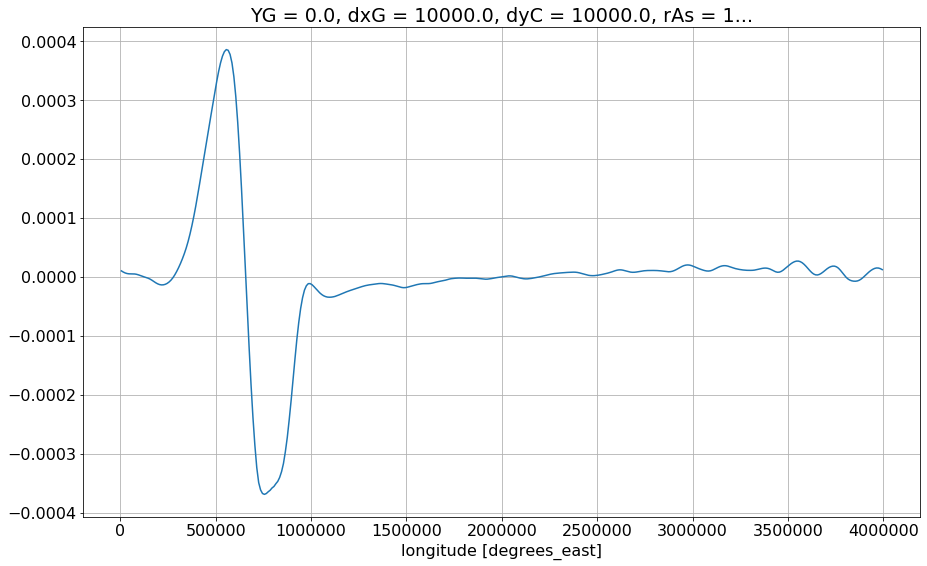

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [41]:
slopes = dzdx/dzdy.where(dzdy>1e-2)
print(slopes)
slopes[19:22].mean(dim=['YC','sigmaF']).plot()
plt.grid()

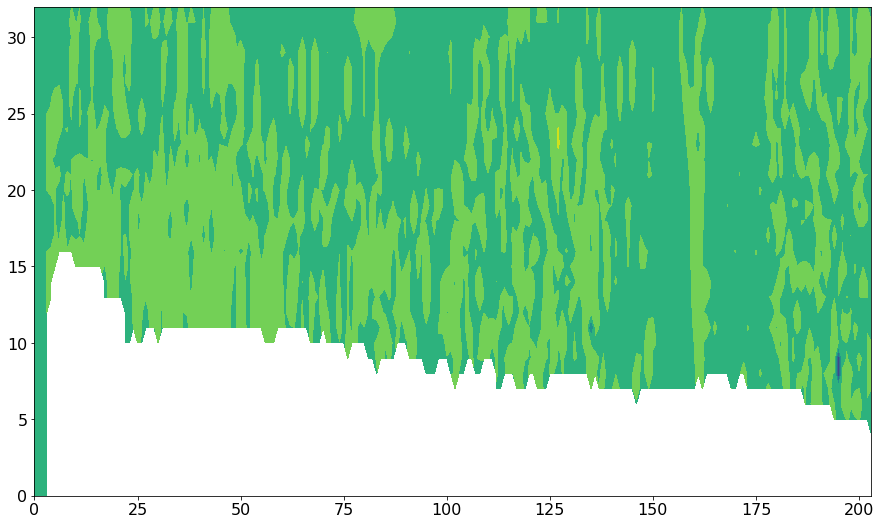